In [1]:
# Import libraries
import cv2
import itertools
import joblib
import numpy as np
import os
import pickle
from PIL import Image, ImageFile
from scipy.spatial.distance import cdist
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights

In [2]:
# Clone repository
%%capture
!git clone https://github.com/filipradenovic/revisitop.git
%cd revisitop/python
!python example_process_images.py

# 1.Bag-of-Visual-Words

In [ ]:
class RootSIFT:
    """
    RootSIFT extractor class.
    """
    def __init__(self):
        """
        Initializes the RootSIFT extractor by creating an instance of OpenCV's SIFT.
        """
        # Initialize the SIFT descriptor extractor from OpenCV
        self.extractor = cv2.SIFT_create()

    def compute(self, image, kps, eps=1e-7):
        """
        Compute RootSIFT descriptors for a set of keypoints in a given image.

        Args:
            image (numpy.ndarray): The input image in grayscale format.
            kps (list): List of detected keypoints in the image.
            eps (float, optional): Small value added to avoid division by zero during normalization.
                Default is 1e-7.

        Returns:
            tuple: A tuple containing:
                - kps (list): List of keypoints (unchanged from input).
                - descs (numpy.ndarray or None): The computed RootSIFT descriptors. If no keypoints are
                  found, this will be None.
        """
        # Compute SIFT descriptors for the given keypoints
        (kps, descs) = self.extractor.compute(image, kps)

        # If no keypoints or descriptors are found, return empty keypoints and None for descriptors
        if len(kps) == 0:
            return ([], None)

        # Apply the Hellinger kernel transformation:
        # 1. Normalize descriptors using L1 normalization (sum of each row equals 1).
        # 2. Take the square root of each descriptor value.
        descs /= (descs.sum(axis=1, keepdims=True) + eps) # L1 normalization
        descs = np.sqrt(descs) # Square root transformation

        return (kps, descs)


def pil_loader(path):
    """
    Load an image from the given file path using the PIL library.

    This function ensures that truncated (corrupted) images are handled gracefully
    to avoid crashes. It returns the image in RGB format.

    Args:
        path (str): The file path to the image.

    Returns:
        PIL.Image.Image: The loaded image converted to RGB format.
    """
    # Allow loading of truncated (corrupted) images without raising errors
    ImageFile.LOAD_TRUNCATED_IMAGES = True

    # Open the image file in binary read mode
    with open(path, 'rb') as f:
        img = Image.open(f) # Open the image using PIL
        return img.convert('RGB') # Convert the image to RGB format


def extract_root_sift(image, max_descriptors=2000):
    """
    Extract RootSIFT descriptors from an input image.

    This function converts the input image from PIL format to OpenCV format, detects keypoints
    using the SIFT algorithm, and then computes RootSIFT descriptors for those keypoints.

    Args:
        image (PIL.Image.Image): Input image in PIL format.
        max_descriptors (int, optional): Maximum number of descriptors to extract. Default is 2000.

    Returns:
        numpy.ndarray: The RootSIFT descriptors for the detected keypoints. If no descriptors
        are found, a zero vector of shape (1, 128) is returned.
    """

    # Convert the input image from PIL format to OpenCV grayscale format
    img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    # Create a SIFT detector with a limit on the number of features
    sift = cv2.SIFT_create(nfeatures=max_descriptors)

    # Detect keypoints in the image
    kps = sift.detect(img_cv)

    # Create an instance of the RootSIFT extractor
    rs = RootSIFT()

    # Compute RootSIFT descriptors for the detected keypoints
    (kps, descriptors) = rs.compute(img_cv, kps)

    # If no descriptors are found, return a zero vector
    if descriptors is None:
        return np.zeros((1, 128), dtype=np.float32)

    # Limit to max_descriptors
    # if len(descriptors) > max_descriptors:
    #     descriptors = descriptors[:max_descriptors]

    return descriptors

In [ ]:
def process_images(dataset):
    """
    Process query and database images to extract and save RootSIFT descriptors.

    Args:
        dataset (str): Name of the dataset to process.

    This function performs the following steps:
    1. Loads the dataset configuration, including the list of query and database images.
    2. Processes query images:
       - Crops the images based on bounding boxes.
       - Extracts RootSIFT descriptors.
       - Saves the descriptors to disk.
    3. Processes database images:
       - Extracts RootSIFT descriptors.
       - Saves the descriptors to disk.
    """

    # Set data root directory
    data_root = os.path.join('/content', 'revisitop', 'data', 'datasets')

    # Load dataset configuration
    with open(os.path.join(data_root, f'{dataset}', f'gnd_{dataset}.pkl'), 'rb') as f:
        data = pickle.load(f)

    # Create directory for saving descriptors
    os.makedirs(os.path.join(data_root, dataset, 'descriptors'), exist_ok=True)

    # Process query images
    print(f"Processing query images for {dataset}")
    for idx, query_img_name in enumerate(data['qimlist']):
        # Load query image
        img_path = os.path.join(data_root, dataset, 'jpg', query_img_name + '.jpg')
        img = pil_loader(img_path)

        # Apply bounding box crop
        bbx = data['gnd'][idx]['bbx']
        cropped_img = img.crop(bbx)

        # Extract descriptors
        descriptors = extract_root_sift(cropped_img)

        # Save descriptors
        np.save(os.path.join(data_root, dataset, 'descriptors', f'{query_img_name}.npy'), descriptors)

        print(f"Processed query image {idx+1}/{len(data['qimlist'])}")


    # Process database images
    print(f"Processing database images for {dataset}")
    for idx, db_img_name in enumerate(data['imlist']):
        # Load database image
        img_path = os.path.join(data_root, dataset, 'jpg', db_img_name+ '.jpg')
        img = pil_loader(img_path)

        # Extract descriptors
        descriptors = extract_root_sift(img)

        # Save descriptors
        np.save(os.path.join(data_root, dataset, 'descriptors', f'{db_img_name}.npy'), descriptors)

        print(f"Processed database image {idx+1}/{len(data['imlist'])}")


def load_descriptors(dataset, query=False):
    """
    Load RootSIFT descriptors for a given dataset.

    Args:
        dataset (str): Name of the dataset to load descriptors from.
        query (bool): If True, load descriptors for query images. Otherwise, load for database images.

    Returns:
        list: A list of descriptors for the specified images. Each entry is a NumPy array.
    """

    data_root = os.path.join('/content', 'revisitop', 'data', 'datasets')

    # Load dataset configuration
    with open(os.path.join(data_root, f'{dataset}', f'gnd_{dataset}.pkl'), 'rb') as f:
        data = pickle.load(f)

    # Choose the appropriate list of images
    img_list = data['qimlist'] if query else data['imlist']

    all_descriptors = []

    # Load descriptors
    for img_name in img_list:
        desc_path = os.path.join(data_root, dataset, 'descriptors', f'{img_name}.npy')
        descriptors = np.load(desc_path)
        all_descriptors.append(descriptors)

    return all_descriptors

## Extracción de Descriptores

In [ ]:
# If you already have the .zip files with the descriptors of each dataset,
# execute this cell instead of the following one.
from google.colab import drive
drive.mount('/content/drive')
# Descriptors of ROxford dataset
!unzip -j "/content/drive/MyDrive/Image Retrieval Project/oxford_descriptors.zip" "content/revisitop/data/datasets/roxford5k/descriptors/*" -d "/content/revisitop/data/datasets/roxford5k/descriptors"
# Descriptors of RParis dataset
!unzip -j "/content/drive/MyDrive/Image Retrieval Project/paris_descriptors.zip" "content/revisitop/data/datasets/rparis6k/descriptors/*" -d "/content/revisitop/data/datasets/rparis6k/descriptors"

Streaming output truncated to the last 5000 lines.
  inflating: /content/revisitop/data/datasets/rparis6k/descriptors/paris_defense_000347.npy  
  inflating: /content/revisitop/data/datasets/rparis6k/descriptors/paris_general_001334.npy  
  inflating: /content/revisitop/data/datasets/rparis6k/descriptors/paris_pantheon_000013.npy  
  inflating: /content/revisitop/data/datasets/rparis6k/descriptors/paris_defense_000553.npy  
  inflating: /content/revisitop/data/datasets/rparis6k/descriptors/paris_invalides_000030.npy  
  inflating: /content/revisitop/data/datasets/rparis6k/descriptors/paris_invalides_000386.npy  
  inflating: /content/revisitop/data/datasets/rparis6k/descriptors/paris_pompidou_000349.npy  
  inflating: /content/revisitop/data/datasets/rparis6k/descriptors/paris_general_000537.npy  
  inflating: /content/revisitop/data/datasets/rparis6k/descriptors/paris_museedorsay_000963.npy  
  inflating: /content/revisitop/data/datasets/rparis6k/descriptors/paris_invalides_000580.npy

In [ ]:
# List of datasets to process
datasets = ['roxford5k', 'rparis6k']

# Iterate over each dataset
for dataset in datasets:
    print(f"Processing {dataset} dataset.")
    process_images(dataset) # Call the function to process images and extract descriptors

    # Path where the extracted descriptors will be stored
    descriptors_path = f'/content/revisitop/data/datasets/{dataset}/descriptors'

    # Check if the descriptors folder exists
    if os.path.exists(descriptors_path):
        # If it exists, compress the descriptors folder into a ZIP file
        !zip -r {descriptors_path}.zip {descriptors_path}
    else:
        # If it doesn't exist, print a message indicating that no descriptors were found
        print(f"No descriptors found for {dataset}, skipping compression.")

Streaming output truncated to the last 5000 lines.
  adding: content/revisitop/data/datasets/rparis6k/descriptors/paris_general_001334.npy (deflated 47%)
  adding: content/revisitop/data/datasets/rparis6k/descriptors/paris_pantheon_000013.npy (deflated 48%)
  adding: content/revisitop/data/datasets/rparis6k/descriptors/paris_defense_000553.npy (deflated 47%)
  adding: content/revisitop/data/datasets/rparis6k/descriptors/paris_invalides_000030.npy (deflated 49%)
  adding: content/revisitop/data/datasets/rparis6k/descriptors/paris_invalides_000386.npy (deflated 53%)
  adding: content/revisitop/data/datasets/rparis6k/descriptors/paris_pompidou_000349.npy (deflated 48%)
  adding: content/revisitop/data/datasets/rparis6k/descriptors/paris_general_000537.npy (deflated 45%)
  adding: content/revisitop/data/datasets/rparis6k/descriptors/paris_museedorsay_000963.npy (deflated 49%)
  adding: content/revisitop/data/datasets/rparis6k/descriptors/paris_invalides_000580.npy (deflated 46%)
  adding: 

## Entrenamiendo

In [ ]:
def train_minibatch_kmeans(descriptor_list, n_clusters=5000, max_iter=10000):
    """
    Train a MiniBatchKMeans model on the given descriptor list.

    Args:
        descriptor_list (list): A list of descriptors for images, each entry is a NumPy array.
        n_clusters (int): Number of clusters for KMeans.
        max_iter (int): Maximum number of iterations for KMeans.

    Returns:
        MiniBatchKMeans: Trained MiniBatchKMeans model.
    """

    # Stack the descriptors into a single array
    all_descriptors = np.vstack(descriptor_list)

    # Initialize the MiniBatchKMeans model
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=42)

    # Train the model
    kmeans.fit(all_descriptors)

    return kmeans


def encode_images(descriptor_list, kmeans, n_clusters):
    """
    Encode images into a histogram representation using KMeans clustering.

    Args:
        descriptor_list (list): List of descriptors for each image.
        kmeans (MiniBatchKMeans): The trained MiniBatchKMeans model.
        n_clusters (int): The number of clusters (K).

    Returns:
        np.ndarray: A matrix where each row corresponds to an image, and each column
                    corresponds to a cluster, representing the term frequency (TF).
    """
    encoded_images = []

    for descriptors in descriptor_list:
        # Predict the closest cluster for each descriptor
        cluster_indices = kmeans.predict(descriptors)

        # Count the occurrences of each cluster (term frequency)
        tf_histogram = np.zeros(n_clusters, dtype=np.float32)
        for idx in cluster_indices:
            tf_histogram[idx] += 1

        encoded_images.append(tf_histogram)

    # Convert the list of histograms into a NumPy array (matrix of size N x K)
    return np.array(encoded_images)


def create_feature_matrices(dataset, kmeans, n_clusters=5000):
    """
    Create the feature matrices for the database and query images.

    Args:
        dataset (str): The name of the dataset ('roxford5k' or 'rparis6k').
        kmeans (MiniBatchKMeans): The trained MiniBatchKMeans model.
        n_clusters (int): The number of clusters (default is 5000).

    Returns:
        tuple: A tuple containing:
            - X (np.ndarray): The term frequency matrix for the database images.
            - Q (np.ndarray): The term frequency matrix for the query images.
    """
    # Load database descriptors
    db_descriptors = load_descriptors(dataset, query=False)

    # Encode database images
    X = encode_images(db_descriptors, kmeans, n_clusters)

    # Load query descriptors
    query_descriptors = load_descriptors(dataset, query=True)

    # Encode query images
    Q = encode_images(query_descriptors, kmeans, n_clusters)

    return X, Q

In [ ]:
# Parameters
n_clusters = 5000
max_iter = 10000

# OXFORD DATASET
# Load database descriptors for ROxford dataset
roxford_db_descriptors = load_descriptors('roxford5k', query=False)
print(f"Total images in ROxford database: {len(roxford_db_descriptors)}")

# Train MiniBatchKMeans model for ROxford descriptors
print("Training MiniBatchKMeans model with ROxford datset.")
roxford_kmeans = train_minibatch_kmeans(roxford_db_descriptors, n_clusters, max_iter)

# Save the trained KMeans models
joblib.dump(roxford_kmeans, '/content/roxford5k_kmeans_model.joblib')
print("ROxford KMeans model saved.")

# PARIS DATASET
# Load database descriptors for RParis dataset
rparis_db_descriptors = load_descriptors('rparis6k', query=False)
print(f"Total images in RParis database: {len(rparis_db_descriptors)}")

# Train MiniBatchKMeans model for RParis descriptors
print("Training MiniBatchKMeans model with RParis datset.")
rparis_kmeans = train_minibatch_kmeans(rparis_db_descriptors, n_clusters, max_iter)

# Save the trained KMeans models
joblib.dump(rparis_kmeans, '/content/rparis6k_kmeans_model.joblib')
print("RParis KMeans model saved.")

Total images in ROxford database: 4993
Training MiniBatchKMeans model with ROxford datset.
ROxford KMeans model saved.
Total images in RParis database: 6322
Training MiniBatchKMeans model with RParis datset.
RParis KMeans model saved.


In [ ]:
# Parameters
n_clusters = 5000
max_iter = 10000

# Load the trained KMeans models
roxford_kmeans_loaded = joblib.load('/content/drive/MyDrive/Image Retrieval Project/roxford5k_kmeans_model.joblib')
print("ROxford KMeans model loaded.")
rparis_kmeans_loaded = joblib.load('/content/drive/MyDrive/Image Retrieval Project/rparis6k_kmeans_model.joblib')
print("RParis KMeans model loaded.")

# Create feature matrices for ROxford and RParis
roxford_X, roxford_Q = create_feature_matrices('roxford5k', roxford_kmeans_loaded, n_clusters)
rparis_X, rparis_Q = create_feature_matrices('rparis6k', rparis_kmeans_loaded, n_clusters)

# Normalize the matrices to have unit norm
roxford_X = normalize(roxford_X, norm='l2', axis=1)
roxford_Q = normalize(roxford_Q, norm='l2', axis=1)
rparis_X = normalize(rparis_X, norm='l2', axis=1)
rparis_Q = normalize(rparis_Q, norm='l2', axis=1)

print("ROxford X matrix shape:", roxford_X.shape)
print("ROxford Q matrix shape:", roxford_Q.shape)
print("RParis X matrix shape:", rparis_X.shape)
print("RParis Q matrix shape:", rparis_Q.shape)

ROxford KMeans model loaded.
RParis KMeans model loaded.
ROxford X matrix shape: (4993, 5000)
ROxford Q matrix shape: (70, 5000)
RParis X matrix shape: (6322, 5000)
RParis Q matrix shape: (70, 5000)


## Evaluación

In [ ]:
def compute_ap(ranks, nres):
    """
    Compute the Average Precision (AP) for a given set of ranked results.

    Average Precision measures the quality of the ranked retrieval system by
    calculating the area under the Precision-Recall curve.

    Args:
        ranks (list or np.ndarray): A sorted list or array of zero-based ranks
                                    of positive (relevant) items in the results.
        nres (int): The total number of positive (relevant) items.

    Returns:
        float: The average precision score, a value between 0 and 1.

    """

    # Total number of ranked items
    nimgranks = len(ranks)

    # Initialize the Average Precision (AP) accumulator
    ap = 0

    # Step size in the recall axis
    recall_step = 1. / nres

    # Accumulate AP using the trapezoid rule
    for j in np.arange(nimgranks):
        rank = ranks[j]

        # Precision excluding the current rank
        if rank == 0:
            precision_0 = 1.
        else:
            precision_0 = float(j) / rank
        # Precision including the current rank
        precision_1 = float(j + 1) / (rank + 1)
        # Update AP
        ap += (precision_0 + precision_1) * recall_step / 2.

    return ap


def compute_map(ranks, gnd, kappas=[]):
    """
    Compute the mean Average Precision (mAP) and related metrics for a set of ranked results.

    This function evaluates the quality of a ranked retrieval system by calculating
    the mAP, average precision for each query, and precision at specified cut-off points (kappas).

    Args:
        ranks (np.ndarray): A 2D array of ranked indexes (shape: [db_size, #queries])
                            where each column contains the ranks of database items for a query.
        gnd (list): A list of dictionaries describing the ground truth for each query.
                    Each dictionary must have the keys:
                    - 'ok': List of positive (relevant) item indexes.
                    - 'junk': (Optional) List of junk (irrelevant) item indexes.
        kappas (list, optional): A list of integer values specifying cut-off points for precision
                                 computation (e.g., [1, 5, 10]).

    Returns:
        tuple: A tuple containing:
            - map (float): The mean Average Precision (mAP) across all queries.
            - aps (np.ndarray): An array of average precision (AP) values for each query.
            - pr (np.ndarray): An array of mean precision values at each k in 'kappas'.
            - prs (np.ndarray): A 2D array where each row contains precision values
                                at each k in 'kappas' for a query.

    Notes:
        - The 'ranks' array is zero-based and should be sorted in ascending order of similarity.
        - Queries without positive (relevant) items are excluded from the mAP calculation.
        - Junk items are ignored when computing ranks of positive items.

    """

    map = 0.
    nq = len(gnd) # Number of queries
    aps = np.zeros(nq)
    pr = np.zeros(len(kappas))
    prs = np.zeros((nq, len(kappas)))
    nempty = 0

    for i in np.arange(nq):
        qgnd = np.array(gnd[i]['ok'])

        # Skip queries without positive items
        if qgnd.shape[0] == 0:
            aps[i] = float('nan')
            prs[i, :] = float('nan')
            nempty += 1
            continue

        try:
            qgndj = np.array(gnd[i]['junk'])
        except:
            qgndj = np.empty(0)

        # Sorted positions of positive and junk items
        pos  = np.arange(ranks.shape[0])[np.in1d(ranks[:,i], qgnd)]
        junk = np.arange(ranks.shape[0])[np.in1d(ranks[:,i], qgndj)]

        # Adjust positions of positive items by excluding junk items
        k = 0;
        ij = 0;
        if len(junk):
            ip = 0
            while (ip < len(pos)):
                while (ij < len(junk) and pos[ip] > junk[ij]):
                    k += 1
                    ij += 1
                pos[ip] = pos[ip] - k
                ip += 1

        # Compute Average Precision (AP)
        ap = compute_ap(pos, len(qgnd))
        map = map + ap
        aps[i] = ap

        # Compute precision at specified cut-off points
        pos += 1 # Convert to 1-based indexing
        for j in np.arange(len(kappas)):
            kq = min(max(pos), kappas[j]);
            prs[i, j] = (pos <= kq).sum() / kq
        pr = pr + prs[i, :]

    # Normalize results by the number of valid queries
    map = map / (nq - nempty)
    pr = pr / (nq - nempty)

    return map, aps, pr, prs


def calculate_ranking(X, Q):
    """
    Calculate the ranking of database items for each query based on cosine similarity.

    This function computes the similarity between a set of database feature vectors and
    query feature vectors, then ranks the database items for each query in descending order
    of similarity.

    Args:
        X (np.ndarray): A 2D array where each row corresponds to a database item's feature vector
                        (shape: [num_database_items, feature_dim]).
        Q (np.ndarray): A 2D array where each row corresponds to a query's feature vector
                        (shape: [num_queries, feature_dim]).

    Returns:
        np.ndarray: A 2D array of ranked indices (shape: [num_database_items, num_queries]),
                    where each column contains the indices of the database items sorted in
                    descending order of similarity to the corresponding query.

    """
    # Compute cosine similarity between database and query feature vectors
    sim = np.dot(X, Q.T)

    # Rank database items in descending order of similarity for each query
    ranks = np.argsort(-sim, axis=0)

    return ranks


def create_gnd(gnd, type_eval):
    """
    Creates a ground truth structure tailored for specific evaluation types.

    This function processes the input ground truth data to group positive and junk items
    based on the evaluation difficulty level ('easy', 'medium', or 'hard').

    Args:
        gnd (list): A list of dictionaries representing the ground truth. Each dictionary contains:
                    - 'easy': List of easy positive item indices.
                    - 'hard': List of hard positive item indices.
                    - 'junk': List of junk item indices.
        type_eval (str): The evaluation type specifying how to group items. Options are:
                         - 'easy': Considers only easy positives, treats hard positives as junk.
                         - 'medium': Considers both easy and hard positives, treats only junk as junk.
                         - 'hard': Considers only hard positives, treats easy positives as junk.

    Returns:
        list: A processed ground truth list where each entry is a dictionary containing:
              - 'ok': Indices of items considered positive for the given evaluation type.
              - 'junk': Indices of items considered junk for the given evaluation type.
    """
    gnd_t = []

    for i in range(len(gnd)):
        g = {}
        if type_eval == 'easy':
            g['ok'] = np.concatenate([gnd[i]['easy']])
            g['junk'] = np.concatenate([gnd[i]['junk'], gnd[i]['hard']])
        elif type_eval == 'medium':
            g['ok'] = np.concatenate([gnd[i]['easy'], gnd[i]['hard']])
            g['junk'] = np.concatenate([gnd[i]['junk']])
        elif type_eval == 'hard':
            g['ok'] = np.concatenate([gnd[i]['hard']])
            g['junk'] = np.concatenate([gnd[i]['junk'], gnd[i]['easy']])

        gnd_t.append(g)

    return gnd_t


def evaluate(ranks, gnd, ks):
    """
    Evaluates ranking performance using different difficulty levels.

    This function computes the mean Average Precision (mAP) and mean Precision
    at different values of 'k' for the given ranks and ground truth data. The
    evaluation is performed separately for three difficulty levels: 'easy',
    'medium', and 'hard'.

    Args:
        ranks (np.ndarray): A matrix of shape (db_size, n_queries) representing
                            the ranked indices for each query.
        gnd (list): Ground truth data as a list of dictionaries. Each dictionary contains:
                    - 'easy': List of easy positive item indices.
                    - 'hard': List of hard positive item indices.
                    - 'junk': List of junk item indices.
        ks (list): List of integers specifying the values of 'k' for precision evaluation.

    Returns:
        None. Prints the mAP and precision at 'k' for each difficulty level.

    """
    # Evaluate for Easy difficulty (E)
    gnd_t = create_gnd(gnd, 'easy')
    mapE, apsE, mprE, prsE = compute_map(ranks, gnd_t, ks)

    # Evaluate for Medium difficulty (M)
    gnd_t = create_gnd(gnd, 'medium')
    mapM, apsM, mprM, prsM = compute_map(ranks, gnd_t, ks)

    # Evaluate for Hard difficulty (H)
    gnd_t = create_gnd(gnd, 'hard')
    mapH, apsH, mprH, prsH = compute_map(ranks, gnd_t, ks)

    # Print evaluation results
    print(f'mAP E: {np.around(mapE*100, decimals=2)}, M: {np.around(mapM*100, decimals=2)}, H: {np.around(mapH*100, decimals=2)}')
    print(f"mP@k{np.array(ks)} (E): {np.around(mprE*100, decimals=2)}, (M): {np.around(mprM*100, decimals=2)}, (H): {np.around(mprH*100, decimals=2)}")

In [ ]:
# Define the root directory for datasets
data_root = os.path.join('/content', 'revisitop', 'data', 'datasets')

# Define the values of k for evaluation metrics (precision@k)
ks = [1, 5, 10]

# -------------------
# ROxford Dataset Evaluation
# -------------------

print("Evaluation over ROxford dataset.")

# Calculate ranking for the ROxford dataset
roxford_ranking = calculate_ranking(roxford_X, roxford_Q)
print(f"ROxford ranking matrix shape: {roxford_ranking.shape}")

# Load ground truth data for the ROxford dataset
with open(os.path.join(data_root, 'roxford5k', 'gnd_roxford5k.pkl'), 'rb') as f:
        gnd_roxford_loaded = pickle.load(f)

# Extract the ground truth information from the loaded data
gnd_roxford_loaded = gnd_roxford_loaded["gnd"]

# Evaluate the ranking performance for ROxford
evaluate(roxford_ranking, gnd_roxford_loaded, ks)

# -------------------
# RParis Dataset Evaluation
# -------------------

print("\nEvaluation over RParis dataset.")

# Calculate ranking for the RParis dataset
rparis_ranking = calculate_ranking(rparis_X, rparis_Q)
print(f"RParis ranking matrix shape: {rparis_ranking.shape}")

# Load ground truth data for the RParis dataset
with open(os.path.join(data_root, 'rparis6k', 'gnd_rparis6k.pkl'), 'rb') as f:
        gnd_rparis_loaded = pickle.load(f)

# Extract the ground truth information from the loaded data
gnd_rparis_loaded=gnd_rparis_loaded["gnd"]

# Evaluate the ranking performance for RParis
evaluate(rparis_ranking, gnd_rparis_loaded, ks)

Evaluation over ROxford dataset.
ROxford ranking matrix shape: (4993, 70)
mAP E: 24.17, M: 18.7, H: 6.35
mP@k[ 1  5 10] (E): [48.53 41.08 36.96], (M): [52.86 38.29 33.82], (H): [21.43 11.5  10.06]

Evaluation over RParis dataset.
RParis ranking matrix shape: (6322, 70)
mAP E: 50.87, M: 38.16, H: 15.54
mP@k[ 1  5 10] (E): [87.14 80.29 77.14], (M): [91.43 84.29 81.14], (H): [54.29 46.86 42.29]


## Resultados

In [ ]:
def calc_ap_best_worst(ranks, gnd):
    """
    Calculates the Average Precision (AP) for each query and selects the queries
    with the best and worst AP. Filters out queries with less than 2 correct images
    or those with no relevant images in the ground truth.

    Args:
        ranks (np.ndarray): A 2D array where each column corresponds to a query
                            and contains the ranking of retrieved images for that query.
        gnd (list): A list of dictionaries containing the ground truth data for each query.
                    Each dictionary contains:
                    - 'ok': List of indices of correct (relevant) images.
                    - 'junk': List of irrelevant images (optional).

    Returns:
        aps (list): A list of Average Precision (AP) values for each query.
        best_query_idx (int): Index of the query with the highest AP.
        worst_query_idx (int): Index of the query with the lowest AP.

    If there are no valid queries (queries with more than 1 correct image), the function returns
    None for the best and worst query indices.
    """
    aps = []  # List to store the Average Precision (AP) values for each query
    valid_queries = [] # List to store the indices of valid queries (those with more than 1 correct image)

    # Iterate over all queries to calculate AP
    for i in range(len(gnd)):
        qgnd = np.array(gnd[i].get('ok', []))  # Get the 'ok' (relevant) images for the current query

        # If there are no correct images or just one, assign AP as 0 and skip processing
        if qgnd.shape[0] == 0:
            aps.append(0) # If no correct images, AP is 0
        else:
            # If there are relevant images, calculate the AP
            pos = np.arange(ranks.shape[0])[np.in1d(ranks[:, i], qgnd)] # Find the positions of correct images in the ranking
            ap = compute_ap(pos, len(qgnd)) # Calculate the AP
            aps.append(ap)

            # Add query to valid queries if it has more than 1 correct image and non-zero AP
            if qgnd.shape[0] > 1 and ap != 0.0:
                valid_queries.append(i)

    # If no valid queries are found (those with more than 1 correct image), return None for best and worst query indices
    if not valid_queries:
        return None, None, None # No valid queries found

    # Select the query with the best AP (highest value) and the query with the worst AP (lowest value)
    best_query_idx = valid_queries[np.argmax([aps[i] for i in valid_queries])]
    worst_query_idx = valid_queries[np.argmin([aps[i] for i in valid_queries])]

    return aps, best_query_idx, worst_query_idx

In [ ]:
# Create ground truth data for 'easy' difficulty level for both ROxford and RParis datasets
gnd_roxford_easy = create_gnd(gnd_roxford_loaded, 'easy')
gnd_rparis_easy = create_gnd(gnd_rparis_loaded, 'easy')

# Calculate Average Precision (AP) for ROxford and RParis datasets,
# and select the query with the best and worst AP
oxford_ap_easy, oxford_best_query_idx, oxford_worst_query_idx = calc_ap_best_worst(roxford_ranking, gnd_roxford_easy)
paris_ap_easy, paris_best_query_idx, paris_worst_query_idx = calc_ap_best_worst(rparis_ranking, gnd_rparis_easy)

# Print the results for ROxford
print(f"ROxford best query: {oxford_best_query_idx} - AP value: {oxford_ap_easy[oxford_best_query_idx]}")
print(f"ROxford worst query: {oxford_worst_query_idx} - AP value: {oxford_ap_easy[oxford_worst_query_idx]}")

# Print the results for RParis
print(f"\nRParis best query: {paris_best_query_idx} - AP value: {paris_ap_easy[paris_best_query_idx]}")
print(f"RParis worst query: {paris_worst_query_idx} - AP value: {paris_ap_easy[paris_worst_query_idx]}")

ROxford best query: 51 - AP value: 0.7505394943736556
ROxford worst query: 63 - AP value: 0.0011739782666700276

RParis best query: 20 - AP value: 0.8879556364849218
RParis worst query: 26 - AP value: 0.0034036406272336182


In [ ]:
def get_top_5_images(ranks, query_idx):
    """
    Retrieves the top 5 ranked images for a given query.

    This function takes the ranking matrix and a query index, then returns
    the indices of the top 5 images according to the ranking for that query.

    Args:
        ranks (np.ndarray): A matrix of shape (db_size, n_queries) representing
                             the ranked indices for each query.
        query_idx (int): The index of the query for which the top 5 images are to be retrieved.

    Returns:
        np.ndarray: An array of the indices of the top 5 images for the given query.
    """
    # Get the top 5 image indices from the ranking matrix for the specified query
    top_5_indices = ranks[:5, query_idx]

    return top_5_indices

In [ ]:
# Get the top 5 ranked images for the best and worst queries from the ROxford dataset
best_oxford_top_5_images = get_top_5_images(roxford_ranking, oxford_best_query_idx)
worst_oxford_top_5_images = get_top_5_images(roxford_ranking, oxford_worst_query_idx)

# Get the top 5 ranked images for the best and worst queries from the RParis dataset
best_paris_top_5_images = get_top_5_images(rparis_ranking, paris_best_query_idx)
worst_paris_top_5_images = get_top_5_images(rparis_ranking, paris_worst_query_idx)

# Print the indices of the top 5 images for the best and worst queries in the ROxford dataset
print(f"Top 5 images for the best query: {best_oxford_top_5_images}")
print(f"Top 5 images for the worst query: {worst_oxford_top_5_images}")

# Print the indices of the top 5 images for the best and worst queries in the RParis dataset
print(f"\nTop 5 images for the best query: {best_paris_top_5_images}")
print(f"Top 5 images for the worst query: {worst_paris_top_5_images}")

Top 5 images for the best query: [  71  281  306 3225 4698]
Top 5 images for the worst query: [3379 3606 1112 2188 3494]

Top 5 images for the best query: [1695 3427 4066 4054 3709]
Top 5 images for the worst query: [2467 6203 6251 1163 3131]


In [ ]:
def plot_images(dataset, ranks, best_query_idx, worst_query_idx, data_root = '/content/revisitop/data/datasets'):
    """
    Plots and saves the query images and their top 5 retrieved images for both the best and worst queries.

    This function visualizes the best and worst queries based on Average Precision (AP) and displays
    the top 5 images retrieved for each query based on the ranking.

    Args:
        dataset (str): The name of the dataset (e.g., 'roxford', 'rparis').
        ranks (np.ndarray): A matrix of shape (db_size, n_queries) representing the ranked indices for each query.
        best_query_idx (int): The index of the best query based on AP.
        worst_query_idx (int): The index of the worst query based on AP.
        data_root (str): The root directory path where the dataset and images are located. Default is '/content/revisitop/data/datasets'.

    Returns:
        None. Saves and displays the combined plot of queries and top 5 images.

    """
    fig, axes = plt.subplots(2, 6, figsize=(18, 6))  # 2 filas, 6 columnas

    # Define the path to the jpg images for the dataset
    jpg_path = f'/content/revisitop/data/datasets/{dataset}/jpg'

    # Load the ground truth data for the dataset (including the query and image lists)
    with open(os.path.join(data_root, dataset, f"gnd_{dataset}.pkl"), 'rb') as f:
        gnd_dataset = pickle.load(f)

    # --- Best Query ---
    # Load the query image for the best query
    query_image_name = f"{gnd_dataset['qimlist'][best_query_idx]}.jpg"
    query_image = Image.open(os.path.join(jpg_path, query_image_name))
    axes[0, 0].imshow(query_image) # Display query image in the first position (top-left)
    axes[0, 0].set_title("Query (Best)") # Title for the best query image
    axes[0, 0].axis('off') # Hide axis

    # Get the top 5 images for the best query from the ranks and display them
    top_5_images = get_top_5_images(ranks, best_query_idx)
    for i, idx in enumerate(top_5_images):
        img_name = f"{gnd_dataset['imlist'][idx]}.jpg" # Get image name from 'imlist'
        img_path = os.path.join(jpg_path, img_name) # Path to the image
        img = Image.open(img_path) # Open the image
        axes[0, i+1].imshow(img) # Display the image in the grid
        axes[0, i+1].set_title(f"Rank {i+1}") # Title for each rank
        axes[0, i+1].axis('off') # Hide axis for each image

    # --- Worst Query ---
    # Load the query image for the worst query
    query_image_name = f"{gnd_dataset['qimlist'][worst_query_idx]}.jpg"
    query_image = Image.open(os.path.join(jpg_path, query_image_name))
    axes[1, 0].imshow(query_image) # Display query image in the second row (left)
    axes[1, 0].set_title("Query (Worst)") # Title for the worst query image
    axes[1, 0].axis('off') # Hide axis

    # Get the top 5 images for the worst query from the ranks and display them
    top_5_images = get_top_5_images(ranks, worst_query_idx)
    for i, idx in enumerate(top_5_images):
        img_name = f"{gnd_dataset['imlist'][idx]}.jpg" # Get image name from 'imlist'
        img_path = os.path.join(jpg_path, img_name) # Path to the image
        img = Image.open(img_path) # Open the image
        axes[1, i+1].imshow(img) # Display the image in the grid
        axes[1, i+1].set_title(f"Rank {i+1}") # Title for each rank
        axes[1, i+1].axis('off') # Hide axis for each image

    # Adjust layout to ensure images and titles fit without overlap
    plt.tight_layout()
    # Save the combined image with queries and their top 5 images
    output_image_path = os.path.join(data_root, dataset, f'{dataset}_queries_results.png')
    plt.savefig(output_image_path)
    plt.show()

In [ ]:
# Plot images for ROxford5k dataset
print("Processing and plotting results for the ROxford5k dataset...")
plot_images('roxford5k', roxford_ranking, oxford_best_query_idx, oxford_worst_query_idx)
print("\n\n")
# Plot images for RParis6k dataset
print("Processing and plotting results for the RParis6k dataset...")
plot_images('rparis6k', rparis_ranking, paris_best_query_idx, paris_worst_query_idx)

Output hidden; open in https://colab.research.google.com to view.

# 2.CNN features

In [ ]:
def extract_features(img, model, preprocess, device):
    """
    Extract features from a single image using a specified model.

    Args:
        img (PIL.Image): Image to process.
        model (torch.nn.Module): Pretrained model for feature extraction.
        preprocess (transforms.Compose): Preprocessing steps for the model.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        torch.Tensor: Feature vector.
    """
    img = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(img)
    return features.squeeze()

def process_images_with_model(dataset, device):
    """
    Process a dataset to extract image features using a pretrained ResNet50 model, save the features,
    and evaluate the ranking performance.

    Args:
        dataset (str): Name of the dataset to process (e.g., 'roxford5k').
        device (torch.device): Device to run the model on (e.g., 'cpu' or 'cuda').

    Returns:
        tuple:
            - ranking (np.ndarray): Ranking matrix (shape: [num_database_items, num_queries]),
              where each column contains the indices of the database items ranked by similarity to the corresponding query.
            - gnd_loaded (list): Ground truth information loaded from the dataset.

    Workflow:
        1. Load a pretrained ResNet50 model and configure it for feature extraction.
        2. Preprocess and extract features for query and database images.
        3. Normalize and save the extracted features as .npy files.
        4. Evaluate the ranking performance using the ground truth data and precision@k metrics.
    """

    # Load pretrained resnet50 model
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove classification head
    model = model.to(device).eval()  # Send model to device and set to evaluation mode

    # Preprocessing pipeline
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Standard input size for resnet50 model
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Define data root
    data_root = os.path.join('/content', 'revisitop', 'data', 'datasets')

    # Load dataset configuration
    with open(os.path.join(data_root, f'{dataset}', f'gnd_{dataset}.pkl'), 'rb') as f:
        data_gnd = pickle.load(f)

    # Initialize lists to store features for queries and database
    query_features_list = []
    db_features_list = []

    # Process query images
    print(f"Processing query images for {dataset} using resnet50")
    for idx, query_img_name in enumerate(data_gnd['qimlist']):
        img_path = os.path.join(data_root, dataset, 'jpg', query_img_name + '.jpg')
        img = pil_loader(img_path)
        features = extract_features(img, model, preprocess, device)
        query_features_list.append(features.cpu().numpy())
        print(f"Processed query image {idx+1}/{len(data_gnd['qimlist'])}")

    # Process database images
    print(f"Processing database images for {dataset} using resnet50")
    for idx, db_img_name in enumerate(data_gnd['imlist']):
        img_path = os.path.join(data_root, dataset, 'jpg', db_img_name + '.jpg')
        img = pil_loader(img_path)
        features = extract_features(img, model, preprocess, device)
        db_features_list.append(features.cpu().numpy())
        print(f"Processed database image {idx+1}/{len(data_gnd['imlist'])}")

    # Convert lists to numpy arrays
    query_features = np.array(query_features_list)
    db_features = np.array(db_features_list)

    # Normalize features
    query_features = normalize(query_features, norm='l2', axis=1)
    db_features = normalize(db_features, norm='l2', axis=1)

    # Create directory for saving descriptors
    os.makedirs(os.path.join(data_root, dataset, 'resnet50_features'), exist_ok=True)

    # Save features as numpy arrays
    np.save(os.path.join(data_root, dataset, 'resnet50_features', 'query_features.npy'), query_features)
    print("Query features saved.")
    np.save(os.path.join(data_root, dataset, 'resnet50_features', 'db_features.npy'), db_features)
    print("Database features saved.")

    # Evaluation
    print("Starting evaluation.")
    # Define the values of k for evaluation metrics (precision@k)
    ks = [1, 5, 10]
    # Calculate ranking for the ROxford dataset
    ranking = calculate_ranking(db_features, query_features)
    print(f"{dataset} ranking matrix shape: {ranking.shape}")

    # Extract the ground truth information from the loaded data
    gnd_loaded = data_gnd["gnd"]

    # Evaluate the ranking performance for ROxford
    evaluate(ranking, gnd_loaded, ks)

    return ranking, gnd_loaded

In [ ]:
# Check if a GPU is available; otherwise, use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Process the 'roxford5k' dataset using the ResNet50 model
resnet_roxford_ranking, resnet_gnd_roxford_loaded = process_images_with_model('roxford5k', device)

Streaming output truncated to the last 5000 lines.
Processing database images for roxford5k using resnet50
Processed database image 1/4993
Processed database image 2/4993
Processed database image 3/4993
Processed database image 4/4993
Processed database image 5/4993
Processed database image 6/4993
Processed database image 7/4993
Processed database image 8/4993
Processed database image 9/4993
Processed database image 10/4993
Processed database image 11/4993
Processed database image 12/4993
Processed database image 13/4993
Processed database image 14/4993
Processed database image 15/4993
Processed database image 16/4993
Processed database image 17/4993
Processed database image 18/4993
Processed database image 19/4993
Processed database image 20/4993
Processed database image 21/4993
Processed database image 22/4993
Processed database image 23/4993
Processed database image 24/4993
Processed database image 25/4993
Processed database image 26/4993
Processed database image 27/4993
Processed d

In [ ]:
# Process the 'rparis6k' dataset using the ResNet50 model
resnet_rparis_ranking, resnet_gnd_rparis_loaded = process_images_with_model('rparis6k', device)

Streaming output truncated to the last 5000 lines.
Processed database image 1329/6322
Processed database image 1330/6322
Processed database image 1331/6322
Processed database image 1332/6322
Processed database image 1333/6322
Processed database image 1334/6322
Processed database image 1335/6322
Processed database image 1336/6322
Processed database image 1337/6322
Processed database image 1338/6322
Processed database image 1339/6322
Processed database image 1340/6322
Processed database image 1341/6322
Processed database image 1342/6322
Processed database image 1343/6322
Processed database image 1344/6322
Processed database image 1345/6322
Processed database image 1346/6322
Processed database image 1347/6322
Processed database image 1348/6322
Processed database image 1349/6322
Processed database image 1350/6322
Processed database image 1351/6322
Processed database image 1352/6322
Processed database image 1353/6322
Processed database image 1354/6322
Processed database image 1355/6322
Proc

In [ ]:
# Create ground truth data for 'easy' difficulty level for both ROxford and RParis datasets
resnet_gnd_roxford_easy = create_gnd(resnet_gnd_roxford_loaded, 'easy')
resnet_gnd_rparis_easy = create_gnd(resnet_gnd_rparis_loaded, 'easy')

# Calculate Average Precision (AP) for ROxford and RParis datasets,
# and select the query with the best and worst AP
resnet_oxford_ap_easy, resnet_oxford_best_query_idx, resnet_oxford_worst_query_idx = calc_ap_best_worst(resnet_roxford_ranking, resnet_gnd_roxford_easy)
resnet_paris_ap_easy, resnet_paris_best_query_idx, resnet_paris_worst_query_idx = calc_ap_best_worst(resnet_rparis_ranking, resnet_gnd_rparis_easy)

# Print the results for ROxford
print(f"ROxford best query: {resnet_oxford_best_query_idx} - AP value: {resnet_oxford_ap_easy[resnet_oxford_best_query_idx]}")
print(f"ROxford worst query: {resnet_oxford_worst_query_idx} - AP value: {resnet_oxford_ap_easy[resnet_oxford_worst_query_idx]}")

# Print the results for RParis
print(f"\nRParis best query: {resnet_paris_best_query_idx} - AP value: {resnet_paris_ap_easy[resnet_paris_best_query_idx]}")
print(f"RParis worst query: {resnet_paris_worst_query_idx} - AP value: {resnet_paris_ap_easy[resnet_paris_worst_query_idx]}")

ROxford best query: 52 - AP value: 0.9592426520609199
ROxford worst query: 56 - AP value: 0.013333283719794678

RParis best query: 55 - AP value: 1.0
RParis worst query: 61 - AP value: 0.02481420793299764


In [ ]:
# Get the top 5 ranked images for the best and worst queries from the ROxford dataset
resnet_best_oxford_top_5_images = get_top_5_images(resnet_roxford_ranking, resnet_oxford_best_query_idx)
resnet_worst_oxford_top_5_images = get_top_5_images(resnet_roxford_ranking, resnet_oxford_worst_query_idx)

# Get the top 5 ranked images for the best and worst queries from the RParis dataset
resnet_best_paris_top_5_images = get_top_5_images(resnet_rparis_ranking, resnet_paris_best_query_idx)
resnet_worst_paris_top_5_images = get_top_5_images(resnet_rparis_ranking, resnet_paris_worst_query_idx)

# Print the indices of the top 5 images for the best and worst queries in the ROxford dataset
print(f"Top 5 images for the best query: {resnet_best_oxford_top_5_images}")
print(f"Top 5 images for the worst query: {resnet_worst_oxford_top_5_images}")

# Print the indices of the top 5 images for the best and worst queries in the RParis dataset
print(f"\nTop 5 images for the best query: {resnet_best_paris_top_5_images}")
print(f"Top 5 images for the worst query: {resnet_worst_paris_top_5_images}")

Top 5 images for the best query: [2319 4706 2268 4902  799]
Top 5 images for the worst query: [ 813 4883 1572 1626  236]

Top 5 images for the best query: [1770 4029 3867 4628 1848]
Top 5 images for the worst query: [5417 3022 5287 4875 1247]


A continuación se muestran las 5 mejores imágenes devueltas para el mejor y peor query obtenidos utilizando características de CNN con el modelo ResNet50.

In [ ]:
# Plot images for ROxford5k dataset
print("Processing and plotting results for the ROxford5k dataset...")
plot_images('roxford5k', resnet_roxford_ranking, resnet_oxford_best_query_idx, resnet_oxford_worst_query_idx)
print("\n\n")
# Plot images for RParis6k dataset
print("Processing and plotting results for the RParis6k dataset...")
plot_images('rparis6k', resnet_rparis_ranking, resnet_paris_best_query_idx, resnet_paris_worst_query_idx)

Output hidden; open in https://colab.research.google.com to view.

A continuación se muestran las 5 mejores imágenes devueltas para la mejor y peor query obtenidas con el método de Bag-of-Visual-Words, pero utilizando el método de características CNN con el modelo ResNet50. En esta sección se realiza una comparación de las imágenes devueltas por ambos métodos para las mismas queries.

In [ ]:
# Plot images for ROxford5k dataset
print("Processing and plotting results for the ROxford5k dataset...")
plot_images('roxford5k', resnet_roxford_ranking, oxford_best_query_idx, oxford_worst_query_idx)
print("\n\n")
# Plot images for RParis6k dataset
print("Processing and plotting results for the RParis6k dataset...")
plot_images('rparis6k', resnet_rparis_ranking, paris_best_query_idx, paris_worst_query_idx)

Output hidden; open in https://colab.research.google.com to view.

# 3.CNN mejorado (Experimentos)

## 3.1.Métodos de re-ranking

In [ ]:

# Features of ROxford dataset
!unzip -j "/content/drive/MyDrive/Image Retrieval Project/roxford_resnet50_features.zip" -d "/content/revisitop/data/datasets/roxford5k/resnet50_features"
# Features of RParis dataset
!unzip -j "/content/drive/MyDrive/Image Retrieval Project/rparis_resnet50_features.zip" -d "/content/revisitop/data/datasets/rparis6k/resnet50_features"

# Load ROxford resnet50 features
test_oxford_db_features = np.load('/content/revisitop/data/datasets/roxford5k/resnet50_features/db_features.npy')
test_oxford_query_features = np.load('/content/revisitop/data/datasets/roxford5k/resnet50_features/query_features.npy')

# Load RParis resnet50 features
test_paris_db_features = np.load('/content/revisitop/data/datasets/rparis6k/resnet50_features/db_features.npy')
test_paris_query_features = np.load('/content/revisitop/data/datasets/rparis6k/resnet50_features/query_features.npy')

Archive:  /content/drive/MyDrive/Image Retrieval Project/roxford_resnet50_features.zip
  inflating: /content/revisitop/data/datasets/roxford5k/resnet50_features/db_features.npy  
  inflating: /content/revisitop/data/datasets/roxford5k/resnet50_features/query_features.npy  
Archive:  /content/drive/MyDrive/Image Retrieval Project/rparis_resnet50_features.zip
  inflating: /content/revisitop/data/datasets/rparis6k/resnet50_features/db_features.npy  
  inflating: /content/revisitop/data/datasets/rparis6k/resnet50_features/query_features.npy  


### 3.1.1. $\alpha$ Query Expansion

In [ ]:
def alpha_query_expansion(query_features, database_features, top_k=10, alpha=3.0):
    """
    Implements Alpha Query Expansion (αQE) for image retrieval refinement.

    Args:
        query_features (np.ndarray): Features of the query image (1 x d dimensional).
        database_features (np.ndarray): Features of all database images (n x d dimensional).
        top_k (int): Number of top results to consider for expansion.
        alpha (float): Power parameter for weighting the similarity scores.

    Returns:
        np.ndarray: Enhanced query features after αQE

    """
    # Validations
    if not isinstance(query_features, np.ndarray) or not isinstance(database_features, np.ndarray):
        raise TypeError("query_features and database_features must be arrays of numpy.")

    if query_features.shape[1] != database_features.shape[1]:
        raise ValueError("The dimensions of the features do not match.")

    if top_k <= 0 or top_k > len(database_features):
        raise ValueError("top_k must be positive and less than the number of images in the database.")

    if alpha <= 0:
        raise ValueError("alpha must be positive.")

    # Compute initial similarities
    similarities = cosine_similarity(query_features.reshape(1, -1), database_features)[0]

    # Get top-k indices and their similarities
    top_indices = np.argsort(similarities)[-top_k:]
    top_similarities = similarities[top_indices]

    # Apply alpha weighting
    weights = np.power(top_similarities, alpha)
    weights = weights / np.sum(weights)  # Normalize weights

    # Compute weighted average of top-k features
    top_k_features = database_features[top_indices]
    weighted_features = np.sum(top_k_features * weights[:, np.newaxis], axis=0)

    # Combine with original query
    enhanced_query = query_features + weighted_features

    # Normalize the enhanced query
    enhanced_query = enhanced_query / np.linalg.norm(enhanced_query)

    return enhanced_query

def retrieve_with_aqe(query_features, database_features, top_k=10, alpha=3.0):
    """
    Perform image retrieval using Alpha Query Expansion.

    Args:
        query_features (np.ndarray): Features of the query image.
        database_features (np.ndarray): Features of all database images.
        top_k (int): Number of top results to consider for expansion.
        alpha (float): Power parameter for weighting.

    Returns:
        np.ndarray: Indices of database images sorted by similarity.
        np.ndarray: Similarity scores for all database images.

    """
    # Apply αQE
    enhanced_query = alpha_query_expansion(query_features, database_features, top_k, alpha)

    # Compute final similarities
    final_similarities = cosine_similarity(enhanced_query.reshape(1, -1), database_features)[0]

    # Sort results
    ranked_indices = np.argsort(final_similarities)[::-1]
    ranked_similarities = final_similarities[ranked_indices]

    return ranked_indices, ranked_similarities

In [ ]:
# List of alpha values to test different parameters for AQE (Average Query Expansion)
alphas = [2.0, 3.0, 4.0, 5.0, 6.0]
# List of top_k values to limit the retrieved results
top_k = [5, 10, 15, 20, 25]
#´Combine the parameters
QE_parameter_combinations = list(itertools.product(alphas, top_k))

dataset= 'roxford5k'
ks = [1, 5, 10]
data_root = os.path.join('/content', 'revisitop', 'data', 'datasets')

# Load the ground truth data
with open(os.path.join(data_root, f'{dataset}', f'gnd_{dataset}.pkl'), 'rb') as f:
        data_gnd = pickle.load(f)

# Extract the ground truth information
gnd_loaded = data_gnd["gnd"]

# Loop through alpha and top_k values to perform retrieval and evaluation
for combo in QE_parameter_combinations:
    alpha, k = combo
    print(f"Alpha: {alpha}, Top K: {k}")

    # Lists to store the calculated rankings and similarities
    ranking = []
    ranking_similarities = []

    # Iterate over the query image features
    for query_idx in range(test_oxford_query_features.shape[0]):
        # Retrieve the indices and similarities of the most relevant images
        ranked_indices, ranked_similarities = retrieve_with_aqe(
            test_oxford_query_features[query_idx], # Features of the current query image
            test_oxford_db_features,               # Features of the database images
            top_k=k,                               # Number of results to retrieve
            alpha=alpha                            # Alpha parameter for AQE
            )
        # Append the results to rankings and similarities lists
        ranking.append(ranked_indices)
        ranking_similarities.append(ranked_similarities)

    # Convert the rankings and similarities lists into numpy arrays
    ranking_array = np.vstack(ranking).T
    ranking_similarities_array = np.vstack(ranking_similarities).T

    # Evaluate the ranking performance
    evaluate(ranking_array, gnd_loaded, ks)
    print("\n")

Alpha: 2.0, Top K: 5
mAP E: 38.81, M: 32.5, H: 12.64
mP@k[ 1  5 10] (E): [55.88 48.97 46.  ], (M): [58.57 53.71 50.29], (H): [28.57 23.57 20.29]


Alpha: 2.0, Top K: 10
mAP E: 37.92, M: 32.03, H: 12.63
mP@k[ 1  5 10] (E): [52.94 47.5  45.03], (M): [55.71 51.71 49.57], (H): [31.43 21.62 19.9 ]


Alpha: 2.0, Top K: 15
mAP E: 37.33, M: 31.6, H: 12.36
mP@k[ 1  5 10] (E): [52.94 46.91 44.39], (M): [54.29 50.29 48.14], (H): [28.57 21.33 19.19]


Alpha: 2.0, Top K: 20
mAP E: 36.96, M: 31.24, H: 12.34
mP@k[ 1  5 10] (E): [52.94 46.67 43.8 ], (M): [54.29 50.29 47.71], (H): [30.   21.05 18.9 ]


Alpha: 2.0, Top K: 25
mAP E: 37.0, M: 31.14, H: 12.06
mP@k[ 1  5 10] (E): [52.94 46.62 44.04], (M): [54.29 49.71 47.86], (H): [28.57 21.33 18.76]


Alpha: 3.0, Top K: 5
mAP E: 39.9, M: 33.02, H: 12.63
mP@k[ 1  5 10] (E): [57.35 49.71 46.74], (M): [60.   53.71 50.29], (H): [28.57 23.57 20.29]


Alpha: 3.0, Top K: 10
mAP E: 37.95, M: 32.05, H: 12.64
mP@k[ 1  5 10] (E): [52.94 47.5  45.05], (M): [55.71 51.7

In [ ]:
dataset= 'rparis6k'
ks = [1, 5, 10]
data_root = os.path.join('/content', 'revisitop', 'data', 'datasets')

# Load the ground truth data
with open(os.path.join(data_root, f'{dataset}', f'gnd_{dataset}.pkl'), 'rb') as f:
        data_gnd = pickle.load(f)

# Extract the ground truth information
gnd_loaded = data_gnd["gnd"]

# Loop through alpha and top_k values to perform retrieval and evaluation
for combo in QE_parameter_combinations:
    alpha, k = combo
    print(f"Alpha: {alpha}, Top K: {k}")

    # Lists to store the calculated rankings and similarities
    ranking = []
    ranking_similarities = []

    # Iterate over the query image features
    for query_idx in range(test_paris_query_features.shape[0]):
        # Retrieve the indices and similarities of the most relevant images
        ranked_indices, ranked_similarities = retrieve_with_aqe(
            test_paris_query_features[query_idx], # Features of the current query image
            test_paris_db_features,               # Features of the database images
            top_k=k,                              # Number of results to retrieve
            alpha=alpha                           # Alpha parameter for AQE
            )
        # Append the results to rankings and similarities lists
        ranking.append(ranked_indices)
        ranking_similarities.append(ranked_similarities)

    # Convert the rankings and similarities lists into numpy arrays
    ranking_array = np.vstack(ranking).T
    ranking_similarities_array = np.vstack(ranking_similarities).T

    # Evaluate the ranking performance
    evaluate(ranking_array, gnd_loaded, ks)
    print("\n")

Alpha: 2.0, Top K: 5
mAP E: 76.16, M: 63.04, H: 36.38
mP@k[ 1  5 10] (E): [95.71 91.14 89.57], (M): [97.14 94.   93.43], (H): [85.71 72.86 69.71]


Alpha: 2.0, Top K: 10
mAP E: 76.9, M: 63.69, H: 37.16
mP@k[ 1  5 10] (E): [95.71 91.71 89.86], (M): [97.14 94.   93.43], (H): [82.86 73.43 70.  ]


Alpha: 2.0, Top K: 15
mAP E: 77.11, M: 63.87, H: 37.34
mP@k[ 1  5 10] (E): [94.29 91.71 90.  ], (M): [95.71 93.71 93.29], (H): [80.   72.57 69.57]


Alpha: 2.0, Top K: 20
mAP E: 76.85, M: 63.84, H: 37.27
mP@k[ 1  5 10] (E): [92.86 92.   90.  ], (M): [95.71 94.   93.29], (H): [80.   72.   69.14]


Alpha: 2.0, Top K: 25
mAP E: 76.83, M: 63.89, H: 37.34
mP@k[ 1  5 10] (E): [92.86 91.71 90.  ], (M): [94.29 94.   93.29], (H): [78.57 72.   68.86]


Alpha: 3.0, Top K: 5
mAP E: 76.17, M: 63.03, H: 36.36
mP@k[ 1  5 10] (E): [95.71 91.14 89.57], (M): [97.14 93.71 93.43], (H): [85.71 72.57 69.71]


Alpha: 3.0, Top K: 10
mAP E: 76.88, M: 63.66, H: 37.12
mP@k[ 1  5 10] (E): [95.71 91.71 89.86], (M): [97.14 9

### 3.1.2. k-Reciprocal

In [ ]:
def re_ranking(query_features, db_features , k1=10, k2=3, lambda_value=0.5):
    """
    Re-ranking algorithm for image retrieval to refine the ranking of database images for each query image.

    This code is based on the repository of the CVPR 2017 paper:
    Zhong Z, Zheng L, Cao D, et al. *Re-ranking Person Re-identification with k-reciprocal Encoding*.
    Available at: http://openaccess.thecvf.com/content_cvpr_2017/papers/Zhong_Re-Ranking_Person_Re-Identification_CVPR_2017_paper.pdf
    GitHub: https://github.com/zhunzhong07/person-re-ranking

    Args:
        query_features (np.ndarray): Features of the query images, shape (num_queries, feature_dim).
        db_features (np.ndarray): Features of the database images, shape (num_db_images, feature_dim).
        k1 (int): Number of nearest neighbors for k-reciprocal expansion.
        k2 (int): Number of nearest neighbors for query expansion.
        lambda_value (float): Weight factor for combining original and Jaccard distances.

    Returns:
        np.ndarray: New ranking of database images for each query, shape (num_db_images, num_queries).
    """

    query_num = query_features.shape[0] # Number of query images
    all_num = query_num + db_features.shape[0] # Total number of images (query + database)

    # Combine query and database features into a single array
    feat = np.append(query_features,db_features,axis = 0)
    feat = feat.astype(np.float16)

    # print('Computing original distance.')

    # Compute the pairwise Euclidean distances between all features
    original_dist = cdist(feat,feat).astype(np.float16)
    original_dist = np.power(original_dist,2).astype(np.float16) # Square the distances

    # Normalize the distances column-wise
    gallery_num = original_dist.shape[0] # Total number of images
    original_dist = np.transpose(original_dist/np.max(original_dist,axis = 0))

    # Initialize variables
    V = np.zeros_like(original_dist).astype(np.float16)
    initial_rank = np.argsort(original_dist).astype(np.int32) # Initial ranking based on original distances

    # print('Starting re-ranking.')

    for i in range(all_num):
        # Step 1: Identify k-reciprocal neighbors
        forward_k_neigh_index = initial_rank[i,:k1+1] # Forward k nearest neighbors
        backward_k_neigh_index = initial_rank[forward_k_neigh_index,:k1+1] # Backward neighbors of the forward neighbors
        fi = np.where(backward_k_neigh_index==i)[0] # Indices of reciprocal neighbors
        k_reciprocal_index = forward_k_neigh_index[fi]

        # Expand k-reciprocal neighbors by considering second-order neighbors
        k_reciprocal_expansion_index = k_reciprocal_index
        for j in range(len(k_reciprocal_index)):
            candidate = k_reciprocal_index[j]
            candidate_forward_k_neigh_index = initial_rank[candidate,:int(np.around(k1/2))+1]
            candidate_backward_k_neigh_index = initial_rank[candidate_forward_k_neigh_index,:int(np.around(k1/2))+1]
            fi_candidate = np.where(candidate_backward_k_neigh_index == candidate)[0]
            candidate_k_reciprocal_index = candidate_forward_k_neigh_index[fi_candidate]

            # Check overlap to determine if candidate is added to expansion
            if len(np.intersect1d(candidate_k_reciprocal_index,k_reciprocal_index))> 2/3*len(candidate_k_reciprocal_index):
                k_reciprocal_expansion_index = np.append(k_reciprocal_expansion_index,candidate_k_reciprocal_index)

        k_reciprocal_expansion_index = np.unique(k_reciprocal_expansion_index)

        # Compute weights for k-reciprocal neighbors
        weight = np.exp(-original_dist[i,k_reciprocal_expansion_index])
        V[i,k_reciprocal_expansion_index] = weight/np.sum(weight)

    # Query expansion (if k2 > 1)
    original_dist = original_dist[:query_num,]
    if k2 != 1:
        V_qe = np.zeros_like(V,dtype=np.float16)
        for i in range(all_num):
            V_qe[i,:] = np.mean(V[initial_rank[i,:k2],:],axis=0)
        V = V_qe

    # Build inverted index for efficient Jaccard distance computation
    invIndex = []
    for i in range(gallery_num):
        invIndex.append(np.where(V[:,i] != 0)[0])

    # Initialize Jaccard distance matrix
    jaccard_dist = np.zeros_like(original_dist,dtype = np.float16)

    for i in range(query_num):
        temp_min = np.zeros(shape=[1,gallery_num],dtype=np.float16)
        indNonZero = np.where(V[i,:] != 0)[0]
        indImages = []
        indImages = [invIndex[ind] for ind in indNonZero]
        for j in range(len(indNonZero)):
            temp_min[0,indImages[j]] = temp_min[0,indImages[j]]+ np.minimum(V[i,indNonZero[j]],V[indImages[j],indNonZero[j]])
        jaccard_dist[i] = 1-temp_min/(2-temp_min)

    # Combine original distances and Jaccard distances
    final_dist = jaccard_dist*(1-lambda_value) + original_dist*lambda_value
    final_dist = final_dist[:query_num,query_num:]

    # Sort final distances to produce the new ranking
    new_ranking = np.argsort(final_dist.T, axis=0)

    return new_ranking

In [ ]:
k1_values = [5, 10, 15, 20]
k2_values = [1, 3, 5, 7]
lambda_values = [0.1, 0.3, 0.5, 0.7, 0.9]
parameter_combinations = list(itertools.product(k1_values, k2_values, lambda_values))

dataset= 'roxford5k'
ks = [1, 5, 10]
data_root = os.path.join('/content', 'revisitop', 'data', 'datasets')

with open(os.path.join(data_root, f'{dataset}', f'gnd_{dataset}.pkl'), 'rb') as f:
        data_gnd = pickle.load(f)

gnd_loaded = data_gnd["gnd"]

for combo in parameter_combinations:
    print(f"k1={combo[0]}, k2={combo[1]}, lambda_value={combo[2]}")
    new_ranking = re_ranking(test_oxford_query_features, test_oxford_db_features, k1=combo[0], k2=combo[1], lambda_value=combo[2])
    evaluate(new_ranking, gnd_loaded, ks)
    print("\n")

k1=5, k2=1, lambda_value=0.1
Computing original distance.
Starting re-ranking.
mAP E: 40.83, M: 33.48, H: 12.97
mP@k[ 1  5 10] (E): [61.76 53.97 48.96], (M): [64.29 56.24 51.24], (H): [31.43 23.33 20.48]


k1=5, k2=1, lambda_value=0.3
Computing original distance.
Starting re-ranking.
mAP E: 40.71, M: 33.44, H: 13.26
mP@k[ 1  5 10] (E): [61.76 53.43 48.57], (M): [65.71 55.14 50.86], (H): [34.29 23.62 20.48]


k1=5, k2=1, lambda_value=0.5
Computing original distance.
Starting re-ranking.
mAP E: 40.75, M: 33.42, H: 13.24
mP@k[ 1  5 10] (E): [61.76 54.02 48.57], (M): [65.71 55.86 50.86], (H): [34.29 23.79 20.36]


k1=5, k2=1, lambda_value=0.7
Computing original distance.
Starting re-ranking.
mAP E: 39.61, M: 32.7, H: 13.17
mP@k[ 1  5 10] (E): [61.76 52.5  47.73], (M): [65.71 54.86 50.82], (H): [34.29 23.14 20.24]


k1=5, k2=1, lambda_value=0.9
Computing original distance.
Starting re-ranking.
mAP E: 39.38, M: 32.36, H: 13.04
mP@k[ 1  5 10] (E): [61.76 52.87 47.5 ], (M): [65.71 55.71 49.71]

In [ ]:
dataset= 'rparis6k'
ks = [1, 5, 10]
data_root = os.path.join('/content', 'revisitop', 'data', 'datasets')

with open(os.path.join(data_root, f'{dataset}', f'gnd_{dataset}.pkl'), 'rb') as f:
        data_gnd = pickle.load(f)

gnd_loaded = data_gnd["gnd"]

for combo in parameter_combinations:
    print(f"k1={combo[0]}, k2={combo[1]}, lambda_value={combo[2]}")
    new_ranking = re_ranking(test_paris_query_features, test_paris_db_features, k1=combo[0], k2=combo[1], lambda_value=combo[2])
    evaluate(new_ranking, gnd_loaded, ks)
    print("\n")

k1=5, k2=1, lambda_value=0.1
Computing original distance.
Starting re-ranking.
mAP E: 74.4, M: 60.97, H: 34.07
mP@k[ 1  5 10] (E): [95.71 91.43 88.71], (M): [98.57 94.   92.43], (H): [75.71 67.14 63.86]


k1=5, k2=1, lambda_value=0.3
Computing original distance.
Starting re-ranking.
mAP E: 74.42, M: 60.98, H: 34.06
mP@k[ 1  5 10] (E): [95.71 91.71 88.57], (M): [98.57 94.   92.29], (H): [74.29 67.14 64.  ]


k1=5, k2=1, lambda_value=0.5
Computing original distance.
Starting re-ranking.
mAP E: 74.4, M: 60.98, H: 34.07
mP@k[ 1  5 10] (E): [95.71 91.71 88.57], (M): [98.57 93.71 92.29], (H): [74.29 66.86 63.86]


k1=5, k2=1, lambda_value=0.7
Computing original distance.
Starting re-ranking.
mAP E: 74.4, M: 60.98, H: 34.08
mP@k[ 1  5 10] (E): [95.71 91.71 88.86], (M): [98.57 94.   92.29], (H): [75.71 67.14 64.  ]


k1=5, k2=1, lambda_value=0.9
Computing original distance.
Starting re-ranking.
mAP E: 74.38, M: 60.99, H: 34.09
mP@k[ 1  5 10] (E): [95.71 91.71 88.86], (M): [98.57 94.   92.43], 

## 3.2.Diferentes capas de Pooling

In [ ]:
class FeatureExtractor(nn.Module):
    """
    FeatureExtractor extracts feature vectors from images using a pre-trained ResNet50 model.
    It supports various pooling methods including Generalized Mean Pooling (GeM), Maximum Activation of Convolutions (MAC),
    Sum-Pooling of Convolutions (SPoC), Cross-dimensional Weighted (CroW) pooling, and Regional Maximum Activation of Convolutions (R-MAC).
    """
    def __init__(self, device, architecture='resnet50', pooling='gem', p=3.0, l=3):
        """
        Initializes the FeatureExtractor.

        Args:
            architecture (str): The architecture to use, default is 'resnet50'.
            pooling (str): The pooling method to use. One of 'gem', 'mac', 'spoc', 'crow', 'rmac'.
            p (float): The parameter p for GeM pooling.
        """
        super(FeatureExtractor, self).__init__()

        # Load the base model (ResNet50)
        if architecture == 'resnet50':
            base_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
            self.features  = nn.Sequential(*list(base_model.children())[:-2])  # Remove avgpool and fc layers
            self.dim = 2048  # Output dimensionality of the features
        else:
            raise ValueError(f"Architecture '{architecture}' is not supported.")

        # Define the pooling method
        self.pooling = pooling.lower()
        if self.pooling == 'gem':
            self.p = nn.Parameter(torch.ones(1) * p) # Parameter p for GeM
        elif self.pooling == 'rmac':
            self.l = l
        elif self.pooling not in ['mac', 'spoc', 'crow']:
            raise ValueError(f"Pooling method '{pooling}' is not supported.")

    def gem(self, x):
        """
        Generalized Mean Pooling (GeM) method.

        """
        p = self.p
        return F.avg_pool2d(x.clamp(min=1e-6).pow(p), (x.size(-2), x.size(-1))).pow(1.0 / p)

    def mac(self, x):
        """
        Maximum Activation of Convolutions (MAC) pooling method.

        """
        return F.max_pool2d(x, (x.size(-2), x.size(-1)))

    def spoc(self, x):
        """
        Sum-Pooling of Convolutions (SPoC) method.

        """
        return F.avg_pool2d(x, (x.size(-2), x.size(-1)))

    def crow(self, x):
        """
        Cross-dimensional Weighted (CroW) pooling method.

        """
        # Calculate spatial weights
        spatial_weight = torch.sum(x, dim=1, keepdim=True)
        z = spatial_weight.mean()
        spatial_weight = torch.sigmoid(spatial_weight - z)

        # Calculate channel weights
        channel_weight = torch.sqrt(torch.sum(x * x, dim=(2, 3), keepdim=True))

        # Apply weights and perform pooling
        x = x * spatial_weight
        x = x * channel_weight
        return F.avg_pool2d(x, (x.size(-2), x.size(-1)))

    def rmac(self, x):
        """
        Regional Maximum Activation of Convolutions (R-MAC).

        Args:
            x (torch.Tensor): Tensor con las características.
            L (int): Número de niveles de pirámide.

        Returns:
            torch.Tensor: Descriptor R-MAC.
        """
        L = self.l
        _, C, H, W = x.size()
        steps = torch.linspace(1, min(H, W), L + 1, device=x.device).round().int()
        regions = []

        for i in range(L):
            for j in range(L):
                h_start = steps[i].item()
                h_end = steps[i + 1].item()
                w_start = steps[j].item()
                w_end = steps[j + 1].item()

                # Extract the region
                region = x[:, :, h_start:h_end, w_start:w_end]
                pooled = F.adaptive_max_pool2d(region, (1, 1))
                regions.append(pooled)

        # Concatenate regions and normalize
        rmac_features = torch.cat(regions, dim=0)
        rmac_features = F.normalize(rmac_features, p=2, dim=1)
        return rmac_features.sum(dim=0, keepdim=True)

    def forward(self, x):
        """
        Forward pass through the FeatureExtractor.

        """
        # Extract features from the backbone (ResNet50)
        x = self.features(x)

        # Apply the selected pooling method
        if self.pooling == 'gem':
            x = self.gem(x)
        elif self.pooling == 'mac':
            x = self.mac(x)
        elif self.pooling == 'spoc':
            x = self.spoc(x)
        elif self.pooling == 'crow':
            x = self.crow(x)
        elif self.pooling == 'rmac':
            x = self.rmac(x)

        # Flatten the tensor to a 1D feature vector
        x = x.view(x.size(0), -1)

        # Normalize the feature vector
        x = F.normalize(x, p=2, dim=1)

        return x

def extract_ms_features(model, image, preprocess, device):
    """
    Extracts features from a given image using a pre-trained model.

    Args:
        model (torch.nn.Module): The pre-trained model used for feature extraction.
        image (PIL.Image or similar): The input image to process.
        preprocess (callable): A preprocessing function to prepare the image (e.g., resizing, normalization).
        device (torch.device): The device (CPU or GPU) where the model and tensors should reside.

    Returns:
        torch.Tensor: The extracted feature vector, squeezed to remove unnecessary dimensions.
    """
    # Preprocess the image
    img = preprocess(image).unsqueeze(0).to(device)
    # Extract features from the model
    with torch.no_grad():
        features = model(img)
    # Remove extra dimensions
    return features.squeeze()

In [ ]:
def pool_test(dataset, pool_list, p_param, l_param, device):
    """
    Tests various pooling methods for feature extraction and evaluates retrieval performance on a dataset.

    Args:
        dataset (str): Name of the dataset (e.g., 'roxford5k', 'rparis6k').
        pool_list (list of str): List of pooling methods to test (e.g., ['gem', 'mac', 'spoc', 'crow']).
        p_param (list of float): Parameters for GeM pooling.
        l_param (list of int): Parameters for RMAC pooling.
        device (torch.device): The device (CPU or GPU) to use for processing.

    Returns:
        None: Prints results for each pooling method tested.
    """

    def process_images(image_list, model, data_root, dataset, preprocess):
        """Extract features for a list of images."""
        features_list = []
        for img_name in image_list:
            img_path = os.path.join(data_root, dataset, 'jpg', f'{img_name}.jpg')
            img = pil_loader(img_path)
            features = extract_ms_features(model, img, preprocess, device)
            features_list.append(features.cpu().numpy())
        return np.array(features_list)

    def evaluate_pooling(model, data_gnd, data_root, dataset, preprocess):
        """Processes query and database images, evaluates, and prints results."""
        query_features = process_images(data_gnd['qimlist'], model, data_root, dataset, preprocess)
        db_features = process_images(data_gnd['imlist'], model, data_root, dataset, preprocess)
        ranking = calculate_ranking(db_features, query_features)
        print(f"{dataset} ranking matrix shape: {ranking.shape}")

        ks = [1, 5, 10]
        gnd_loaded = data_gnd['gnd']
        evaluate(ranking, gnd_loaded, ks)
        print("\n")

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    data_root = os.path.join('/content', 'revisitop', 'data', 'datasets')

    with open(os.path.join(data_root, f'{dataset}', f'gnd_{dataset}.pkl'), 'rb') as f:
        data_gnd = pickle.load(f)

    for pooling in pool_list:
        if pooling == 'gem':
            for p in p_param:
                print(f"Testing {pooling} pooling with p={p} for {dataset}")
                model = FeatureExtractor(
                    device=device,
                    architecture='resnet50',
                    pooling=pooling,
                    p=p
                ).to(device).eval()
                evaluate_pooling(model, data_gnd, data_root, dataset, preprocess)

        elif pooling == 'rmac':
            for l in l_param:
                print(f"Testing {pooling} pooling with l={l} for {dataset}")
                model = FeatureExtractor(
                    device=device,
                    architecture='resnet50',
                    pooling=pooling,
                    l=l
                ).to(device).eval()
                evaluate_pooling(model, data_gnd, data_root, dataset, preprocess)

        else:
            print(f"Testing {pooling} pooling for {dataset}")
            model = FeatureExtractor(
                device=device,
                architecture='resnet50',
                pooling=pooling
            ).to(device).eval()
            evaluate_pooling(model, data_gnd, data_root, dataset, preprocess)

        print("=" * 50)
        print("\n")

In [ ]:
# Test over ROxford dataset
dataset = 'roxford5k'

# Define the list of pooling methods to evaluate
pool_list = ['mac', 'spoc', 'crow', 'gem','rmac']

# Parameters for GeM and R-MAC pooling
p_param = [1.0, 2.0, 3.0, 4.0, 5.0]  # p-values for GeM pooling
l_param = [1, 2, 3, 4, 5]  # l-values for R-MAC pooling

# Set the computation device (use GPU if available, otherwise fallback to CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run tests for the specified dataset, pooling methods, and parameters
pool_test(dataset, pool_list, p_param, l_param, device)

Testing mac pooling for roxford5k
roxford5k ranking matrix shape: (4993, 70)
mAP E: 29.29, M: 26.04, H: 11.59
mP@k[ 1  5 10] (E): [48.53 42.35 39.41], (M): [54.29 47.71 43.86], (H): [31.43 21.71 19.14]




Testing spoc pooling for roxford5k
roxford5k ranking matrix shape: (4993, 70)
mAP E: 38.95, M: 31.66, H: 11.86
mP@k[ 1  5 10] (E): [60.29 52.03 47.31], (M): [61.43 55.14 49.86], (H): [28.57 22.43 19.  ]




Testing crow pooling for roxford5k
roxford5k ranking matrix shape: (4993, 70)
mAP E: 32.65, M: 27.37, H: 9.76
mP@k[ 1  5 10] (E): [57.35 46.03 41.21], (M): [60.   48.29 43.79], (H): [17.14 19.14 17.78]




Testing gem pooling with p=1.0 for roxford5k
roxford5k ranking matrix shape: (4993, 70)
mAP E: 38.95, M: 31.66, H: 11.86
mP@k[ 1  5 10] (E): [60.29 52.03 47.31], (M): [61.43 55.14 49.86], (H): [28.57 22.43 19.  ]


Testing gem pooling with p=2.0 for roxford5k
roxford5k ranking matrix shape: (4993, 70)
mAP E: 36.76, M: 30.72, H: 12.57
mP@k[ 1  5 10] (E): [55.88 49.17 45.88], (M):

In [ ]:
# Test over RParis dataset
dataset = 'rparis6k'

# Define the list of pooling methods to evaluate
pool_list = ['mac', 'spoc', 'crow', 'gem','rmac']

# Parameters for GeM and R-MAC pooling
p_param = [1.0, 2.0, 3.0, 4.0, 5.0]  # p-values for GeM pooling
l_param = [1, 2, 3, 4, 5]  # l-values for R-MAC pooling

# Set the computation device (use GPU if available, otherwise fallback to CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run tests for the specified dataset, pooling methods, and parameters
pool_test(dataset, pool_list, p_param, l_param, device)

Testing mac pooling for rparis6k
rparis6k ranking matrix shape: (6322, 70)
mAP E: 67.48, M: 53.36, H: 26.13
mP@k[ 1  5 10] (E): [95.71 93.14 90.14], (M): [97.14 95.14 93.14], (H): [72.86 57.43 49.86]




Testing spoc pooling for rparis6k
rparis6k ranking matrix shape: (6322, 70)
mAP E: 74.18, M: 60.98, H: 34.07
mP@k[ 1  5 10] (E): [95.71 91.71 88.71], (M): [97.14 94.   92.43], (H): [74.29 67.43 63.86]




Testing crow pooling for rparis6k
rparis6k ranking matrix shape: (6322, 70)
mAP E: 70.81, M: 58.13, H: 31.11
mP@k[ 1  5 10] (E): [91.43 88.   86.  ], (M): [92.86 91.14 89.71], (H): [62.86 59.43 56.57]




Testing gem pooling with p=1.0 for rparis6k
rparis6k ranking matrix shape: (6322, 70)
mAP E: 74.18, M: 60.98, H: 34.07
mP@k[ 1  5 10] (E): [95.71 91.71 88.71], (M): [97.14 94.   92.43], (H): [74.29 67.43 63.86]


Testing gem pooling with p=2.0 for rparis6k
rparis6k ranking matrix shape: (6322, 70)
mAP E: 75.42, M: 60.85, H: 33.27
mP@k[ 1  5 10] (E): [95.71 93.14 90.71], (M): [98.57 9

## 3.3.Capa de Pooling + re-ranking

In [ ]:
def return_map(ranks, gnd, ks):
    """
    Evaluate the ranking results using mean Average Precision (mAP) and mean Precision at k (mP@k).

    Args:
        ranks (numpy.ndarray): Ranking matrix where each row corresponds to the ranked indices for a query.
        gnd (dict): Ground truth dictionary containing the evaluation sets (easy, medium, hard).
        ks (list[int]): List of values for k (e.g., [1, 5, 10]) for mP@k computation.

    Returns:
        tuple: mAP and mP@k for easy, medium, and hard difficulty levels.
    """
    # Evaluate for Easy difficulty (E)
    gnd_t = create_gnd(gnd, 'easy')
    mapE, apsE, mprE, prsE = compute_map(ranks, gnd_t, ks)

    # Evaluate for Medium difficulty (M)
    gnd_t = create_gnd(gnd, 'medium')
    mapM, apsM, mprM, prsM = compute_map(ranks, gnd_t, ks)

    # Evaluate for Hard difficulty (H)
    gnd_t = create_gnd(gnd, 'hard')
    mapH, apsH, mprH, prsH = compute_map(ranks, gnd_t, ks)

    return mapE, mapM, mapH, mprE, mprM, mprH

def pool_re_ranking(dataset, pool_list, p_param, l_param, k1_values, k2_values, lambda_values, device):
    """
    Evaluate pooling strategies and perform re-ranking for image retrieval tasks.

    Args:
        dataset (str): Dataset name (e.g., "roxford5k" or "rparis6k").
        pool_list (list[str]): List of pooling layers to evaluate (e.g., ['gem', 'mac', 'spoc']).
        p_param (list[float]): List of `p` values for GeM pooling.
        l_param (list[float]): List of `l` values for R-MAC pooling.
        k1_values (list[int]): List of k1 values for re-ranking.
        k2_values (list[int]): List of k2 values for re-ranking.
        lambda_values (list[float]): List of lambda values for re-ranking.
        device (torch.device): Device to use for computation (e.g., CPU or GPU).

    """

    def process_images(image_list, model, data_root, dataset, preprocess):
        """
        Extract features for a list of images using a specified model.

        Args:
            image_list (list[str]): List of image names to process.
            model (torch.nn.Module): Model for feature extraction.
            data_root (str): Root directory containing the datasets.
            dataset (str): Name of the dataset.
            preprocess (torchvision.transforms.Compose): Preprocessing transformations.

        Returns:
            numpy.ndarray: Array of extracted features for all images.
        """
        features_list = []
        for img_name in image_list:
            img_path = os.path.join(data_root, dataset, 'jpg', f'{img_name}.jpg')
            img = pil_loader(img_path) # Load image
            features = extract_ms_features(model, img, preprocess, device) # Extract features
            features_list.append(features.cpu().numpy())
        return np.array(features_list)

    def evaluate_pooling_re_ranking(model, data_gnd, data_root, dataset, preprocess, parameter_combinations):
        """
        Evaluate pooling and re-ranking parameters and select the best combination.

        Args:
            model (torch.nn.Module): Model for feature extraction.
            data_gnd (dict): Ground truth data loaded from the dataset.
            data_root (str): Root directory containing the datasets.
            dataset (str): Name of the dataset.
            preprocess (torchvision.transforms.Compose): Preprocessing transformations.
            parameter_combinations (list[tuple]): List of tuples with (k1, k2, lambda) for re-ranking.

        """
        # Process query and database images
        query_features = process_images(data_gnd['qimlist'], model, data_root, dataset, preprocess)
        db_features = process_images(data_gnd['imlist'], model, data_root, dataset, preprocess)

        # Initialize evaluation metrics
        ks = [1, 5, 10]
        gnd_loaded = data_gnd['gnd']
        best_map = 0.0
        best_map_dict = {"mapE":0.0, "mapM":0.0, "mapH":0.0, "mprE":[], "mprM":[], "mprH":[]}
        best_re_ranking = {"k1":0.0, "k2":0.0, "lambda":0.0}

        # Iterate over re-ranking parameter combinations
        for combo in parameter_combinations:
            new_ranking = re_ranking(query_features, db_features, k1=combo[0], k2=combo[1], lambda_value=combo[2])
            mapE, mapM, mapH, mprE, mprM, mprH = return_map(new_ranking, gnd_loaded, ks)

            # Update best metrics if a new best mAP for Easy difficulty is found
            if mapE > best_map:
                best_map = mapE
                best_map_dict.update({"mapE": mapE, "mprE": mprE, "mapM": mapM, "mprM": mprM, "mapH": mapH, "mprH": mprH})
                best_re_ranking.update({"k1": combo[0], "k2": combo[1], "lambda": combo[2]})

        # Print the best results
        print(f'Best result with re-ranking parameters k1={best_re_ranking["k1"]}, k2={best_re_ranking["k2"]}, lambda={best_re_ranking["lambda"]}')
        print(f'mAP E: {np.around(best_map_dict["mapE"]*100, decimals=2)}, M: {np.around(best_map_dict["mapM"]*100, decimals=2)}, H: {np.around(best_map_dict["mapH"]*100, decimals=2)}')
        print(f'mP@k{np.array(ks)} (E): {np.around(best_map_dict["mprE"]*100, decimals=2)}, (M): {np.around(best_map_dict["mprM"]*100, decimals=2)}, (H): {np.around(best_map_dict["mprH"]*100, decimals=2)}')

    # Preprocessing transformations
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Generate all combinations of re-ranking parameters
    parameter_combinations = list(itertools.product(k1_values, k2_values, lambda_values))

    # Load ground truth data
    data_root = os.path.join('/content', 'revisitop', 'data', 'datasets')
    with open(os.path.join(data_root, f'{dataset}', f'gnd_{dataset}.pkl'), 'rb') as f:
        data_gnd = pickle.load(f)

    # Evaluate each pooling method
    for pooling in pool_list:
        if pooling == 'gem':
            for p in p_param:
                print(f"Testing {pooling} pooling with p={p} for {dataset}")
                model = FeatureExtractor(
                    device=device,
                    architecture='resnet50',
                    pooling=pooling,
                    p=p
                ).to(device).eval()
                evaluate_pooling_re_ranking(model, data_gnd, data_root, dataset, preprocess, parameter_combinations)

        else:
            for l in l_param:
                print(f"Testing {pooling} pooling with l={l} for {dataset}")
                model = FeatureExtractor(
                    device=device,
                    architecture='resnet50',
                    pooling=pooling,
                    l=l
                ).to(device).eval()
                evaluate_pooling_re_ranking(model, data_gnd, data_root, dataset, preprocess, parameter_combinations)

        print("=" * 50)
        print("\n")

In [ ]:
# Test over ROxford dataset
dataset = 'roxford5k'

# Define the pooling methods and their parameters
pool_list = ['gem','rmac'] # List of pooling methods to evaluate: GeM and R-MAC
p_param = [1.0, 2.0, 3.0] # Parameters for GeM pooling
l_param = [1, 2, 3] # Parameters for R-MAC pooling

# Define re-ranking parameters
k1_values = [5, 10, 15, 20] # Values for k1 parameter in re-ranking
k2_values = [1, 3, 5, 7] # Values for k2 parameter in re-ranking
lambda_values = [0.1, 0.3, 0.5, 0.7, 0.9] # Values for lambda parameter in re-ranking

# Set the device for computation (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluate the specified pooling methods and re-ranking parameters on the dataset
pool_re_ranking(dataset, pool_list, p_param, l_param, k1_values, k2_values, lambda_values, device)

Testing gem pooling with p=1.0 for roxford5k
Best result with re-ranking parameters k1=20, k2=5, lambda=0.5
mAP E: 49.5, M: 38.29, H: 13.44
mP@k[ 1  5 10] (E): [64.71 57.94 54.94], (M): [65.71 54.86 51.  ], (H): [30.   25.33 22.48]
Testing gem pooling with p=2.0 for roxford5k
Best result with re-ranking parameters k1=20, k2=3, lambda=0.3
mAP E: 46.11, M: 37.43, H: 15.84
mP@k[ 1  5 10] (E): [58.82 54.53 51.51], (M): [62.86 55.71 51.12], (H): [28.57 25.71 24.  ]
Testing gem pooling with p=3.0 for roxford5k
Best result with re-ranking parameters k1=20, k2=3, lambda=0.3
mAP E: 45.25, M: 36.29, H: 15.34
mP@k[ 1  5 10] (E): [57.35 54.63 51.99], (M): [62.86 52.57 49.  ], (H): [28.57 24.57 22.64]


Testing rmac pooling with l=1 for roxford5k
Best result with re-ranking parameters k1=15, k2=3, lambda=0.5
mAP E: 44.66, M: 36.34, H: 16.26
mP@k[ 1  5 10] (E): [63.24 59.17 52.25], (M): [62.86 59.62 54.31], (H): [31.43 29.   26.24]
Testing rmac pooling with l=2 for roxford5k
Best result with re-rank

In [ ]:
# Test over RParis dataset
dataset = 'rparis6k'

# Define the pooling methods and their parameters
pool_list = ['gem','rmac'] # List of pooling methods to evaluate: GeM and R-MAC
p_param = [1.0, 2.0, 3.0] # Parameters for GeM pooling
l_param = [1, 2, 3] # Parameters for R-MAC pooling

# Define re-ranking parameters
k1_values = [5, 10, 15, 20] # Values for k1 parameter in re-ranking
k2_values = [1, 3, 5, 7] # Values for k2 parameter in re-ranking
lambda_values = [0.1, 0.3, 0.5, 0.7, 0.9] # Values for lambda parameter in re-ranking

# Set the device for computation (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluate the specified pooling methods and re-ranking parameters on the dataset
pool_re_ranking(dataset, pool_list, p_param, l_param, k1_values, k2_values, lambda_values, device)

Testing gem pooling with p=1.0 for rparis6k
Best result with re-ranking parameters k1=20, k2=7, lambda=0.1
mAP E: 78.97, M: 65.32, H: 38.07
mP@k[ 1  5 10] (E): [92.86 91.43 88.14], (M): [94.29 95.14 92.71], (H): [75.71 70.57 64.57]
Testing gem pooling with p=2.0 for rparis6k
Best result with re-ranking parameters k1=20, k2=7, lambda=0.1
mAP E: 82.85, M: 68.31, H: 40.42
mP@k[ 1  5 10] (E): [95.71 92.86 90.71], (M): [97.14 96.29 95.  ], (H): [88.57 77.14 68.14]
Testing gem pooling with p=3.0 for rparis6k
Best result with re-ranking parameters k1=20, k2=7, lambda=0.1
mAP E: 81.92, M: 67.61, H: 39.49
mP@k[ 1  5 10] (E): [95.71 92.57 90.14], (M): [95.71 95.14 94.29], (H): [78.57 74.86 68.43]


Testing rmac pooling with l=1 for rparis6k
Best result with re-ranking parameters k1=20, k2=7, lambda=0.3
mAP E: 81.87, M: 67.5, H: 40.12
mP@k[ 1  5 10] (E): [95.71 91.81 90.81], (M): [95.71 94.57 94.43], (H): [80.   79.43 69.71]
Testing rmac pooling with l=2 for rparis6k
Best result with re-ranking p

## 3.4.CNN Mejorado

En general:

- Para **ROxford**, **R-MAC** es significativamente mejor, con un rendimiento más alto en **mAP** y en las métricas de precisión **mP@k**.

- Para **RParis**, **GeM** tiene un rendimiento superior en **mAP** y también un desempeño competitivo en las métricas de precisión.

Sin embargo, al considerar ambos datasets y los niveles de dificultad más altos (M, H), **R-MAC** muestra un rendimiento más consistente, especialmente en el dataset más desafiante (ROxford, con un aumento considerable en mAP y mP@k). Esto sugiere que **R-MAC** es más robusto en general, mientras que **GeM** brilla particularmente en condiciones más favorables, como en **RParis**.


In [ ]:
def resnet50_rmac(dataset, pool_layer, l_param, ranking_params, device, save_features=True):
    """
    Evaluate ResNet50 with R-MAC pooling on a given dataset.

    Args:
        dataset (str): Name of the dataset (e.g., 'roxford5k', 'rparis6k').
        pool_layer (str): Pooling layer to use (e.g., 'rmac').
        l_param (int): Parameter for R-MAC pooling (number of regions).
        ranking_params (tuple): Parameters for re-ranking (k1, k2, lambda_value).
        device (torch.device): Device to use for computation (CPU or GPU).
        save_features (bool): Whether to save extracted features to disk.

    Returns:
        new_ranking (numpy.ndarray): Re-ranked matrix.
        gnd_loaded (dict): Ground truth data for evaluation.
    """

    def process_images(image_list, model, data_root, dataset, preprocess):
        """
        Extract features for a list of images.

        Args:
            image_list (list): List of image names.
            model (torch.nn.Module): Feature extraction model.
            data_root (str): Root directory of the dataset.
            dataset (str): Dataset name.
            preprocess (torchvision.transforms.Compose): Preprocessing pipeline.

        Returns:
            numpy.ndarray: Extracted features for the images.
        """
        features_list = []
        for img_name in image_list:
            img_path = os.path.join(data_root, dataset, 'jpg', f'{img_name}.jpg')
            img = pil_loader(img_path) # Load the image
            features = extract_ms_features(model, img, preprocess, device) # Extract features
            features_list.append(features.cpu().numpy())
        return np.array(features_list)

    def evaluate_pooling(model, data_gnd, data_root, dataset, ranking_params, preprocess):
        """
        Processes query and database images, applies re-ranking, and evaluates results.

        Args:
            model (torch.nn.Module): Feature extraction model.
            data_gnd (dict): Ground truth data for queries and database.
            data_root (str): Root directory of the dataset.
            dataset (str): Dataset name.
            ranking_params (tuple): Parameters for re-ranking.
            preprocess (torchvision.transforms.Compose): Preprocessing pipeline.

        Returns:
            new_ranking (numpy.ndarray): Re-ranked matrix.
            gnd_loaded (dict): Ground truth data for evaluation.
        """

        print("Processing query images...")
        query_features = process_images(data_gnd['qimlist'], model, data_root, dataset, preprocess)

        print("Processing database images...")
        db_features = process_images(data_gnd['imlist'], model, data_root, dataset, preprocess)

        if save_features:
            # Create directory for saving features
            os.makedirs(os.path.join(data_root, dataset, 'resnet50_improved_features'), exist_ok=True)

            # Save features as numpy arrays
            np.save(os.path.join(data_root, dataset, 'resnet50_improved_features', 'query_features.npy'), query_features)
            print("Query features saved.")
            np.save(os.path.join(data_root, dataset, 'resnet50_improved_features', 'db_features.npy'), db_features)
            print("Database features saved.")


        print("Applying re-ranking...")
        new_ranking = re_ranking(query_features,
                                 db_features,
                                 k1=ranking_params[0],
                                 k2=ranking_params[1],
                                 lambda_value=ranking_params[2]
                                 )
        print(f"{dataset} ranking matrix shape: {new_ranking.shape}.")

        print("Evaluating results...")
        ks = [1, 5, 10]
        gnd_loaded = data_gnd['gnd']
        evaluate(new_ranking, gnd_loaded, ks) # Evaluate using mAP and precision@k

        return new_ranking, gnd_loaded

    # Preprocessing pipeline
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Set the root directory for datasets
    data_root = os.path.join('/content', 'revisitop', 'data', 'datasets')

    # Load ground truth data for the specified dataset
    with open(os.path.join(data_root, f'{dataset}', f'gnd_{dataset}.pkl'), 'rb') as f:
        data_gnd = pickle.load(f)

    print(f"Evaluating ResNet50 with {pool_layer} pooling and l={l_param} for {dataset}")
    print(f"Re-ranking parameters: k1={ranking_params[0]}, k2={ranking_params[1]}, lambda={ranking_params[2]}")
    print("\n")

    # Initialize the feature extraction model
    model = FeatureExtractor(
        device=device,
        architecture='resnet50',
        pooling=pool_layer,
        l=l_param
    ).to(device).eval()

    # Perform evaluation with pooling and re-ranking
    new_ranking, gnd_loaded = evaluate_pooling(model, data_gnd, data_root, dataset, ranking_params, preprocess)

    return new_ranking, gnd_loaded

In [ ]:
# Test over ROxford dataset
dataset = 'roxford5k'

# Specify pooling layer and parameters for the evaluation
pool_layer = 'rmac'  # Use R-MAC pooling
l_param = 2  # Number of regions for R-MAC pooling

# Define re-ranking parameters
ranking_params = [20, 5, 0.3] # [k1, k2, lambda_value]

# Set the computation device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Perform evaluation using ResNet50 with R-MAC pooling
# Returns the re-ranked similarity matrix and ground truth data
newResnet_roxford_ranking, newResnet_gnd_roxford = resnet50_rmac(dataset, pool_layer, l_param, ranking_params, device)

Evaluating ResNet50 with rmac pooling and l=2 for roxford5k
Re-ranking parameters: k1=20, k2=5, lambda=0.3


Processing query images...
Processing database images...
Query features saved.
Database features saved.
Applying re-ranking...
roxford5k ranking matrix shape: (4993, 70).
Evaluating results...
mAP E: 59.79, M: 43.02, H: 14.1
mP@k[ 1  5 10] (E): [72.06 70.05 65.7 ], (M): [72.86 61.52 56.29], (H): [31.43 27.   23.1 ]


In [ ]:
# Test over ROxford dataset
dataset = 'rparis6k'

# Specify pooling layer and parameters for the evaluation
pool_layer = 'rmac'  # Use R-MAC pooling
l_param = 1  # Number of regions for R-MAC pooling

# Define re-ranking parameters
ranking_params = [20, 7, 0.3] # [k1, k2, lambda_value]

# Set the computation device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Perform evaluation using ResNet50 with R-MAC pooling
# Returns the re-ranked similarity matrix and ground truth data
newResnet_rparis_ranking, newResnet_gnd_rparis = resnet50_rmac(dataset, pool_layer, l_param, ranking_params, device)

Evaluating ResNet50 with rmac pooling and l=1 for rparis6k
Re-ranking parameters: k1=20, k2=7, lambda=0.3


Processing query images...
Processing database images...
Query features saved.
Database features saved.
Applying re-ranking...
rparis6k ranking matrix shape: (6322, 70).
Evaluating results...
mAP E: 81.87, M: 67.5, H: 40.12
mP@k[ 1  5 10] (E): [95.71 91.81 90.81], (M): [95.71 94.57 94.43], (H): [80.   79.43 69.71]


In [ ]:
# Create ground truth data for 'easy' difficulty level for both ROxford and RParis datasets
newResnet_gnd_roxford_easy = create_gnd(newResnet_gnd_roxford, 'easy')
newResnet_gnd_rparis_easy = create_gnd(newResnet_gnd_rparis, 'easy')

# Calculate Average Precision (AP) for ROxford and RParis datasets,
# and select the query with the best and worst AP
newResnet_oxford_ap_easy, newResnet_oxford_best_query_idx, newResnet_oxford_worst_query_idx = calc_ap_best_worst(newResnet_roxford_ranking, newResnet_gnd_roxford_easy)
newResnet_paris_ap_easy, newResnet_paris_best_query_idx, newResnet_paris_worst_query_idx = calc_ap_best_worst(newResnet_rparis_ranking, newResnet_gnd_rparis_easy)

# Print the results for ROxford
print(f"ROxford best query: {newResnet_oxford_best_query_idx} - AP value: {newResnet_oxford_ap_easy[newResnet_oxford_best_query_idx]}")
print(f"ROxford worst query: {newResnet_oxford_worst_query_idx} - AP value: {newResnet_oxford_ap_easy[newResnet_oxford_worst_query_idx]}")

# Print the results for RParis
print(f"\nRParis best query: {newResnet_paris_best_query_idx} - AP value: {newResnet_paris_ap_easy[newResnet_paris_best_query_idx]}")
print(f"RParis worst query: {newResnet_paris_worst_query_idx} - AP value: {newResnet_paris_ap_easy[newResnet_paris_worst_query_idx]}")

ROxford best query: 25 - AP value: 1.0
ROxford worst query: 63 - AP value: 0.008322414060394016

RParis best query: 20 - AP value: 0.945797751324774
RParis worst query: 59 - AP value: 0.033726802721996685


In [ ]:
# Get the top 5 ranked images for the best and worst queries from the ROxford dataset
newResnet_best_oxford_top_5_images = get_top_5_images(newResnet_roxford_ranking, newResnet_oxford_best_query_idx)
newResnet_worst_oxford_top_5_images = get_top_5_images(newResnet_roxford_ranking, newResnet_oxford_worst_query_idx)

# Get the top 5 ranked images for the best and worst queries from the RParis dataset
newResnet_best_paris_top_5_images = get_top_5_images(newResnet_rparis_ranking, newResnet_paris_best_query_idx)
newResnet_worst_paris_top_5_images = get_top_5_images(newResnet_rparis_ranking, newResnet_paris_worst_query_idx)

# Print the indices of the top 5 images for the best and worst queries in the ROxford dataset
print(f"ROxford top 5 images for the best query: {newResnet_best_oxford_top_5_images}")
print(f"ROxford top 5 images for the worst query: {newResnet_worst_oxford_top_5_images}")

# Print the indices of the top 5 images for the best and worst queries in the RParis dataset
print(f"\nRParis top 5 images for the best query: {newResnet_best_paris_top_5_images}")
print(f"RParis top 5 images for the worst query: {newResnet_worst_paris_top_5_images}")

ROxford top 5 images for the best query: [2785 1625 2468 3751 2533]
ROxford top 5 images for the worst query: [2403 4767 4031  230 4202]

RParis top 5 images for the best query: [3804 1181 1505 3148 6280]
RParis top 5 images for the worst query: [4184  180 4623 1098 5854]


In [ ]:
# Plot images for ROxford5k dataset
print("Processing and plotting results for the ROxford5k dataset...")
plot_images('roxford5k', newResnet_roxford_ranking, newResnet_oxford_best_query_idx, newResnet_oxford_worst_query_idx)
print("\n\n")
# Plot images for RParis6k dataset
print("Processing and plotting results for the RParis6k dataset...")
plot_images('rparis6k', newResnet_rparis_ranking, newResnet_paris_best_query_idx, newResnet_paris_worst_query_idx)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Plot images for ROxford5k dataset
print("Processing and plotting results for the ROxford5k dataset...")
plot_images('roxford5k', newResnet_roxford_ranking, oxford_best_query_idx, oxford_worst_query_idx)
print("\n\n")
# Plot images for RParis6k dataset
print("Processing and plotting results for the RParis6k dataset...")
plot_images('rparis6k', newResnet_rparis_ranking, paris_best_query_idx, paris_worst_query_idx)

Output hidden; open in https://colab.research.google.com to view.

# 4.Evaluación de Indexación y PCA

In [ ]:
!unzip -j "/content/drive/MyDrive/Image Retrieval Project/roxford_resnet50_rmac_features.zip" -d "/content/revisitop/data/datasets/roxford5k/resnet50_improved_features"
!unzip -j "/content/drive/MyDrive/Image Retrieval Project/rparis_resnet50_rmac_features.zip" -d "/content/revisitop/data/datasets/rparis6k/resnet50_improved_features"

# Load ROxford resnet50 + rmac features
test_roxford_db_features = np.load('/content/revisitop/data/datasets/roxford5k/resnet50_improved_features/db_features.npy')
test_roxford_query_features = np.load('/content/revisitop/data/datasets/roxford5k/resnet50_improved_features/query_features.npy')
print(f"ROxford database features shape: {test_roxford_db_features.shape}")
print(f"ROxford query features shape: {test_roxford_query_features.shape}")

# Load RParis resnet50 + rmac features
test_rparis_db_features = np.load('/content/revisitop/data/datasets/rparis6k/resnet50_improved_features/db_features.npy')
test_rparis_query_features = np.load('/content/revisitop/data/datasets/rparis6k/resnet50_improved_features/query_features.npy')
print(f"RParis database features shape: {test_rparis_db_features.shape}")
print(f"RParis query features shape: {test_rparis_query_features.shape}")

Archive:  /content/drive/MyDrive/Image Retrieval Project/roxford_resnet50_rmac_features.zip
replace /content/revisitop/data/datasets/roxford5k/resnet50_improved_features/db_features.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/revisitop/data/datasets/roxford5k/resnet50_improved_features/query_features.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  /content/drive/MyDrive/Image Retrieval Project/rparis_resnet50_rmac_features.zip
replace /content/revisitop/data/datasets/rparis6k/resnet50_improved_features/db_features.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/revisitop/data/datasets/rparis6k/resnet50_improved_features/query_features.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
ROxford database features shape: (4993, 2048)
ROxford query features shape: (70, 2048)
RParis database features shape: (6322, 2048)
RParis query features shape: (70, 2048)


In [ ]:
# Install pyflann
!pip install pyflann-py3

In [ ]:
import time
import pyflann

def evaluar_busqueda(nns, dists, tiempo, nns_LS, dists_LS):
    """
    Evaluates the quality of the search by comparing the results obtained
    with an index (such as KDTree or KMeansTree) with the results from
    an exact Linear Scan.

    Args:
        nns (list): List of indices of the nearest neighbors found by the
                    current search method (e.g., KDTree or KMeansTree).
        dists (list): List of distances corresponding to the nearest neighbors
                      found by the current search method.
        tiempo (float): The time taken by the current search in seconds.
        nns_LS (list): List of indices of the nearest neighbors obtained
                      through Linear Scan (exact reference).
        dists_LS (list): List of distances corresponding to the nearest
                      neighbors obtained through Linear Scan (exact reference).

    Returns:
        tuple: A tuple containing:
            - precision (float): The precision of the current search, expressed as a percentage.
            - efficiency (float): The efficiency of the current search, expressed as a percentage.
            - correct (int): Number of correct results (exact matches).
            - incorrect (int): Number of incorrect results (non-matches).
    """
    # Initialize variables to count correct and incorrect results
    correct = 0
    incorrect = 0

    # Iterate through the results of the linear search (nns_LS and dists_LS)
    for i in range(len(nns_LS)):
      # If the index or distance from the current search matches the linear search, it's correct
      if nns[i] == nns_LS[i] or dists[i] == dists_LS[i]:
        correct += 1 # Increment the correct count
      else:
        incorrect += 1 # Increment the incorrect count

    # Calculate precision as the percentage of correct results
    precision = 100 * correct / (correct + incorrect)

    # Calculate efficiency as the time of the current search divided by the time of the linear search
    efficiency = 100 * tiempo / segundos_LS

    return precision, efficiency, correct, incorrect

In [ ]:
# Create a FLANN object
flann = pyflann.FLANN()

# Build the index for the database features using the 'linear' algorithm for an exact linear scan
flann.build_index(test_roxford_db_features, algorithm='linear')

# Measure the time taken for the linear scan search
t0 = time.time()

# Perform the search for the k-nearest neighbors (k=1 for 1-Nearest Neighbor)
nns_LS, dists_LS = flann.nn_index(test_roxford_query_features, num_neighbors=1, cores=1)

# Calculate the time taken for the search
segundos_LS = time.time() - t0

# Evaluate the results of the search
precision, efficiency, correct, incorrect = evaluar_busqueda(nns_LS, dists_LS, segundos_LS, nns_LS, dists_LS)

# Print the results
print("LinearScan - Time[s]: {: .2f}".format(segundos_LS))  # Total search time in seconds
print("LinearScan - Precision: {:.1f}%".format(precision))  # Precision as a percentage
print("LinearScan - Efficiency: {:.1f}%".format(efficiency))  # Efficiency compared to linear scan time
print("LinearScan - Correct: {}/Incorrect: {}".format(correct, incorrect))  # Counts of correct and incorrect results

LinearScan - Time[s]:  0.62
LinearScan - Precision: 100.0%
LinearScan - Efficiency: 100.0%
LinearScan - Correct: 70/Incorrect: 0


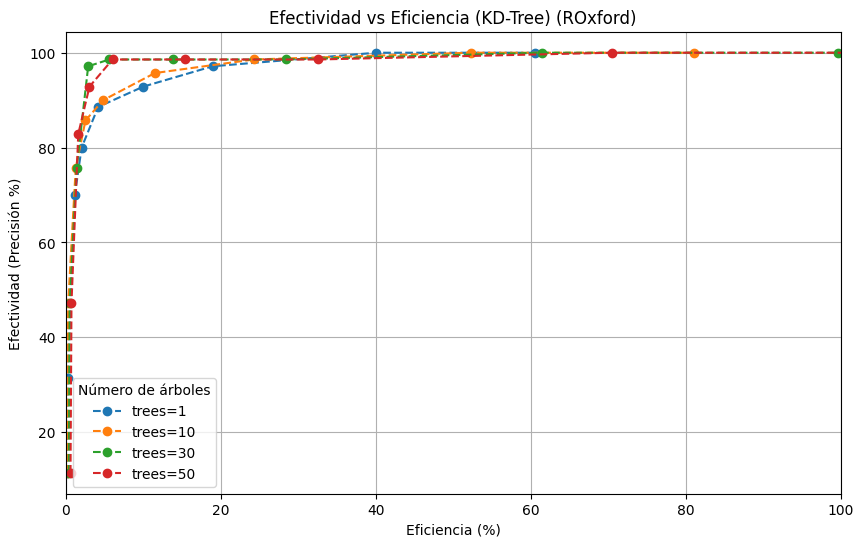

In [ ]:
# Initialize the FLANN object
flann = pyflann.FLANN()

# Values to test for the KD-Tree parameters
trees_values = [1, 10, 30, 50]  # Number of trees for the KD-Tree
checks_values = [1, 10, 50, 100, 200, 500, 1000, 2000, 3000]  # Number of checks to control the trade-off

# Dictionary to store results for different parameter combinations
resultados = {}

# Perform evaluation for different combinations of 'trees' and 'checks' parameters
for trees in trees_values:
    precisiones = []  # List to store precision results for the current 'trees' value
    eficiencias = []  # List to store efficiency results for the current 'trees' value

    # Build the KD-Tree index with the current number of trees
    flann.build_index(test_roxford_db_features, algorithm='kdtree', trees=trees)

    # Test the search with different values for 'checks'
    for checks in checks_values:
        t0 = time.time()
        # Perform the 1-Nearest Neighbor search with the specified number of checks
        nns_KDTree, dists_KDTree = flann.nn_index(test_roxford_query_features, num_neighbors=1, cores=1, checks=checks)
        segundos_KDTree = time.time() - t0 # Measure the search time

        # Evaluate the search results compared to the Linear Scan
        precision_KDTree, eficiencia_KDTree, _, _ = evaluar_busqueda(nns_KDTree, dists_KDTree, segundos_KDTree, nns_LS, dists_LS)

        # Append the results for the current 'checks' value
        precisiones.append(precision_KDTree)
        eficiencias.append(eficiencia_KDTree)

    # Store results for the current 'trees' value
    resultados[trees] = {"eficiencias": eficiencias, "precisiones": precisiones}

# Plot the results
plt.figure(figsize=(10, 6))
for trees, data in resultados.items():
    # Plot each curve with efficiency on the x-axis and precision on the y-axis
    plt.plot(data["eficiencias"], data["precisiones"], label=f"trees={trees}", marker='o', linestyle='dashed')

# Configure the plot
plt.xlim(0, 100)
plt.title("Efectividad vs Eficiencia (KD-Tree) (ROxford)")
plt.xlabel("Eficiencia (%)")
plt.ylabel("Efectividad (Precisión %)")
plt.grid(True)
plt.legend(title="Número de árboles")
plt.show()

PCA: 32 dimensiones


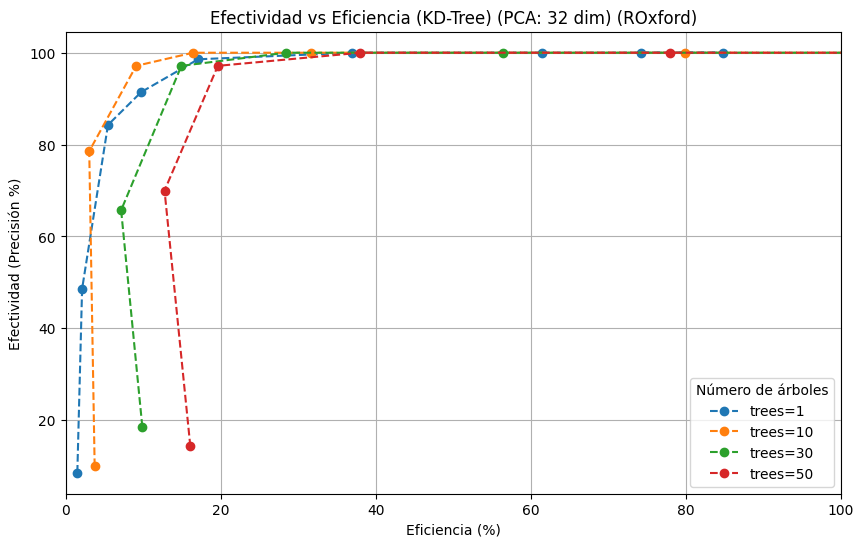

PCA: 64 dimensiones


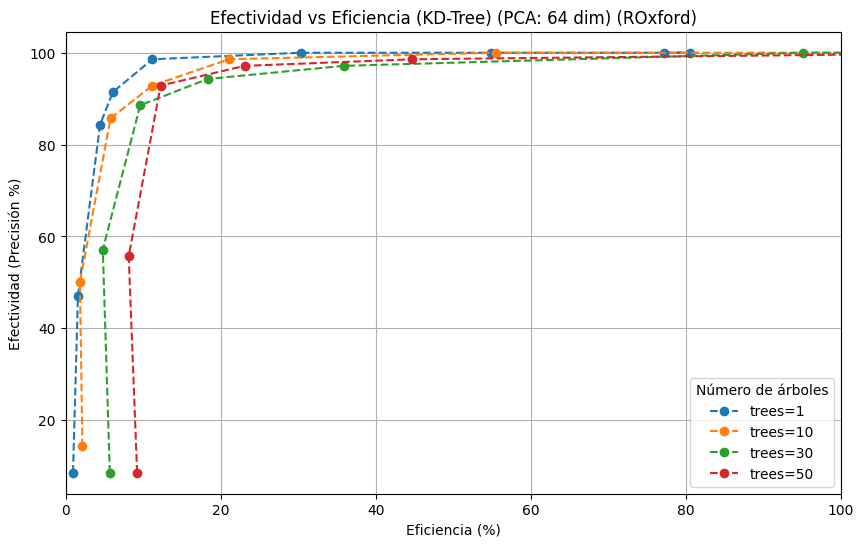

PCA: 128 dimensiones


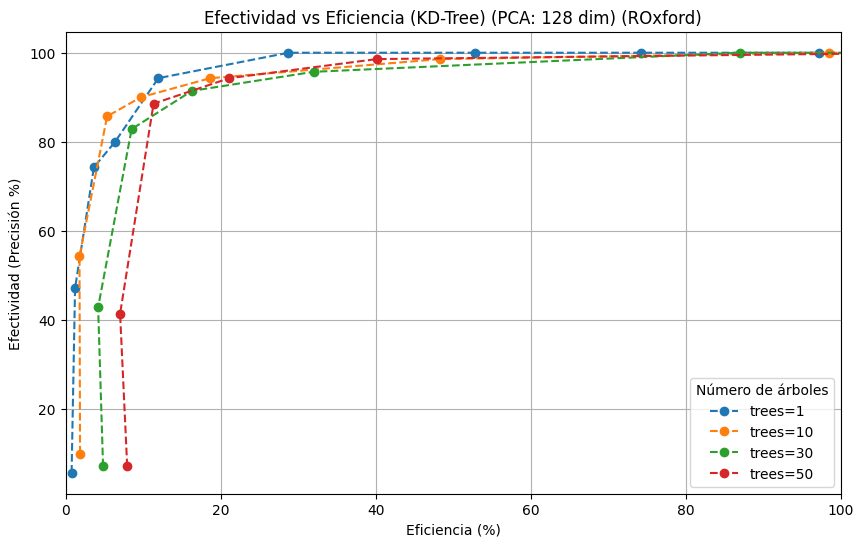

PCA: 256 dimensiones


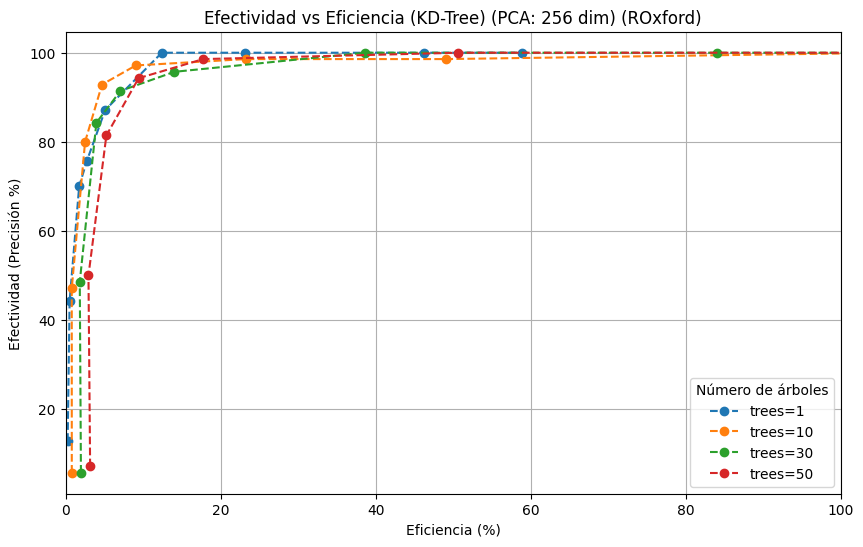

PCA: 512 dimensiones


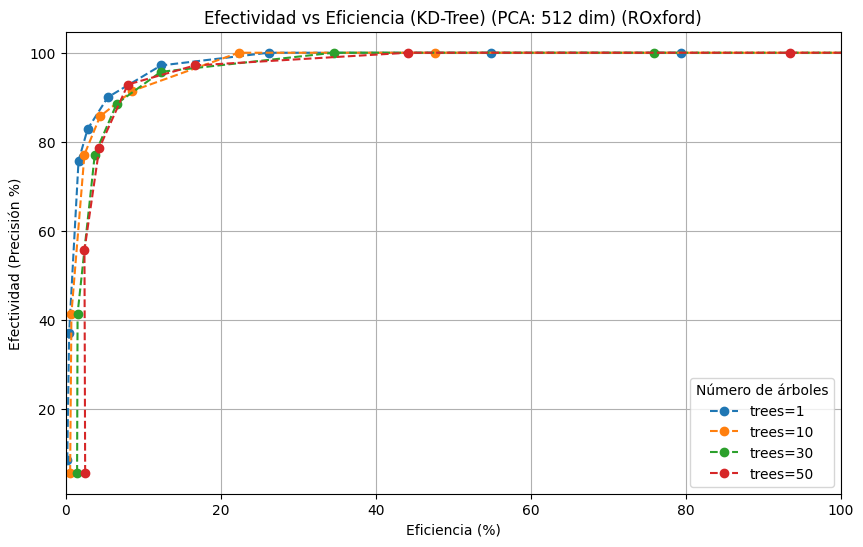

PCA: 1024 dimensiones


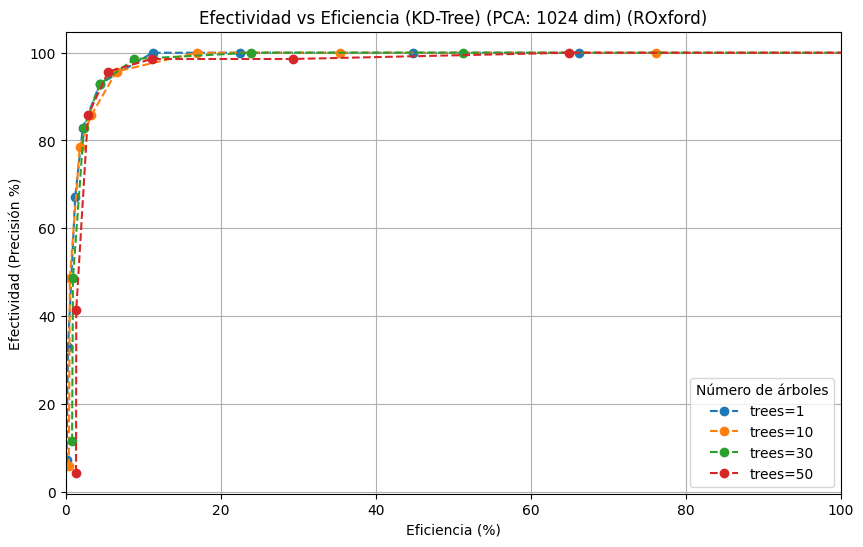

In [ ]:
from sklearn.decomposition import PCA

# Define dimensions for PCA reduction
dimensiones = [32, 64, 128, 256, 512, 1024]  # PCA dimensions to test
trees_values = [1, 10, 30, 50]  # Number of trees for KD-Tree
checks_values = [1, 10, 50, 100, 200, 500, 1000, 2000, 3000]  # Number of checks to control trade-off

# Loop through the different PCA dimensions
for dim in dimensiones:
    print(f"PCA: {dim} dimensiones")

    # Apply PCA to reduce dimensionality of the database and query features
    pca = PCA(n_components=dim)
    db_features_pca = pca.fit_transform(test_roxford_db_features) # Reduce the database features
    query_features_pca = pca.transform(test_roxford_query_features) # Reduce the query features

    # Create a FLANN object for Linear Scan
    flann = pyflann.FLANN()
    # Build the index using the 'linear' algorithm for an exact search
    flann.build_index(db_features_pca, algorithm='linear')
    # Measure the time for the Linear Scan
    t0 = time.time()
    # Perform the 1-Nearest Neighbor search
    nns_LS, dists_LS = flann.nn_index(query_features_pca, num_neighbors=1, cores=1)
    # Calculate the time taken for the search
    segundos_LS = time.time() - t0

    # Dictionary to store results for the KD-Tree searches
    resultados = {}

    # Loop through the different values of 'trees' for KD-Tree
    for trees in trees_values:
        precisiones = []  # Store precision results for the current 'trees' value
        eficiencias = []  # Store efficiency results for the current 'trees' value

        # Initialize a new FLANN object for KD-Tree search
        flann = pyflann.FLANN()
        # Build the KD-Tree index with the current number of trees
        flann.build_index(db_features_pca, algorithm='kdtree', trees=trees)

        # Test the KD-Tree search with different 'checks' values
        for checks in checks_values:
            t0 = time.time()
            # Perform the 1-Nearest Neighbor search using KD-Tree
            nns_KDTree, dists_KDTree = flann.nn_index(query_features_pca, num_neighbors=1, cores=1, checks=checks)
            segundos_KDTree = time.time() - t0 # Measure the search time

            # Evaluate the KD-Tree search results against the Linear Scan baseline
            precision_KDTree, eficiencia_KDTree, _, _ = evaluar_busqueda(nns_KDTree, dists_KDTree, segundos_KDTree, nns_LS, dists_LS)

            # Append the results for the current 'checks' value
            precisiones.append(precision_KDTree)
            eficiencias.append(eficiencia_KDTree)

        # Store the results for the current 'trees' value
        resultados[trees] = {"eficiencias": eficiencias, "precisiones": precisiones}

    # Plot the results for the current PCA dimension
    plt.figure(figsize=(10, 6))
    for trees, data in resultados.items():
        # Plot each curve with efficiency on the x-axis and precision on the y-axis
        plt.plot(data["eficiencias"], data["precisiones"], label=f"trees={trees}", marker='o', linestyle='dashed')

    # Configure the plot
    plt.xlim(0, 100)
    plt.title(f"Efectividad vs Eficiencia (KD-Tree) (PCA: {dim} dim) (ROxford)")
    plt.xlabel("Eficiencia (%)")
    plt.ylabel("Efectividad (Precisión %)")
    plt.grid(True)
    plt.legend(title="Número de árboles")
    plt.show()

In [ ]:
# Create a FLANN object
flann = pyflann.FLANN()

# Build the index for the database features using the 'linear' algorithm for an exact linear scan
flann.build_index(test_rparis_db_features, algorithm='linear')

# Measure the time taken for the linear scan search
t0 = time.time()

# Perform the search for the k-nearest neighbors (k=1 for 1-Nearest Neighbor)
nns_LS, dists_LS = flann.nn_index(test_rparis_query_features, num_neighbors=1, cores=1)

# Calculate the time taken for the search
segundos_LS = time.time() - t0

# Evaluate the results of the search
precision, efficiency, correct, incorrect = evaluar_busqueda(nns_LS, dists_LS, segundos_LS, nns_LS, dists_LS)

# Print the results
print("LinearScan - Time[s]: {: .2f}".format(segundos_LS))  # Total search time in seconds
print("LinearScan - Precision: {:.1f}%".format(precision))  # Precision as a percentage
print("LinearScan - Efficiency: {:.1f}%".format(efficiency))  # Efficiency compared to linear scan time
print("LinearScan - Correct: {}/Incorrect: {}".format(correct, incorrect))  # Counts of correct and incorrect results

LinearScan - Time[s]:  0.80
LinearScan - Precision: 100.0%
LinearScan - Efficiency: 100.0%
LinearScan - Correct: 70/Incorrect: 0


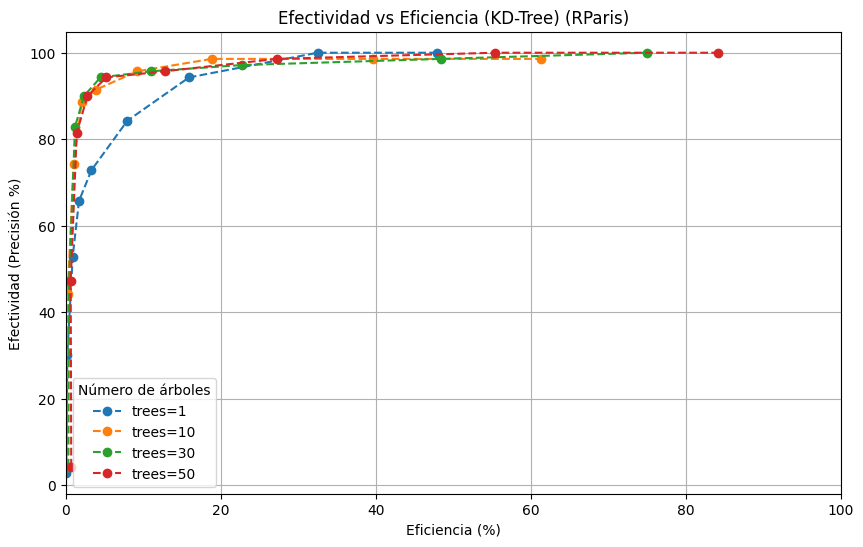

In [ ]:
# Initialize the FLANN object
flann = pyflann.FLANN()

# Values to test for the KD-Tree parameters
trees_values = [1, 10, 30, 50]  # Number of trees for the KD-Tree
checks_values = [1, 10, 50, 100, 200, 500, 1000, 2000, 3000]  # Number of checks to control the trade-off

# Dictionary to store results for different parameter combinations
resultados = {}

# Perform evaluation for different combinations of 'trees' and 'checks' parameters
for trees in trees_values:
    precisiones = []  # List to store precision results for the current 'trees' value
    eficiencias = []  # List to store efficiency results for the current 'trees' value

    # Build the KD-Tree index with the current number of trees
    flann.build_index(test_rparis_db_features, algorithm='kdtree', trees=trees)

    # Test the search with different values for 'checks'
    for checks in checks_values:
        t0 = time.time()
        # Perform the 1-Nearest Neighbor search with the specified number of checks
        nns_KDTree, dists_KDTree = flann.nn_index(test_rparis_query_features, num_neighbors=1, cores=1, checks=checks)
        segundos_KDTree = time.time() - t0 # Measure the search time

        # Evaluate the search results compared to the Linear Scan
        precision_KDTree, eficiencia_KDTree, _, _ = evaluar_busqueda(nns_KDTree, dists_KDTree, segundos_KDTree, nns_LS, dists_LS)

        # Append the results for the current 'checks' value
        precisiones.append(precision_KDTree)
        eficiencias.append(eficiencia_KDTree)

    # Store results for the current 'trees' value
    resultados[trees] = {"eficiencias": eficiencias, "precisiones": precisiones}

# Plot the results
plt.figure(figsize=(10, 6))
for trees, data in resultados.items():
    # Plot each curve with efficiency on the x-axis and precision on the y-axis
    plt.plot(data["eficiencias"], data["precisiones"], label=f"trees={trees}", marker='o', linestyle='dashed')

# Configure the plot
plt.xlim(0, 100)
plt.title("Efectividad vs Eficiencia (KD-Tree) (RParis)")
plt.xlabel("Eficiencia (%)")
plt.ylabel("Efectividad (Precisión %)")
plt.grid(True)
plt.legend(title="Número de árboles")
plt.show()

PCA: 32 dimensiones


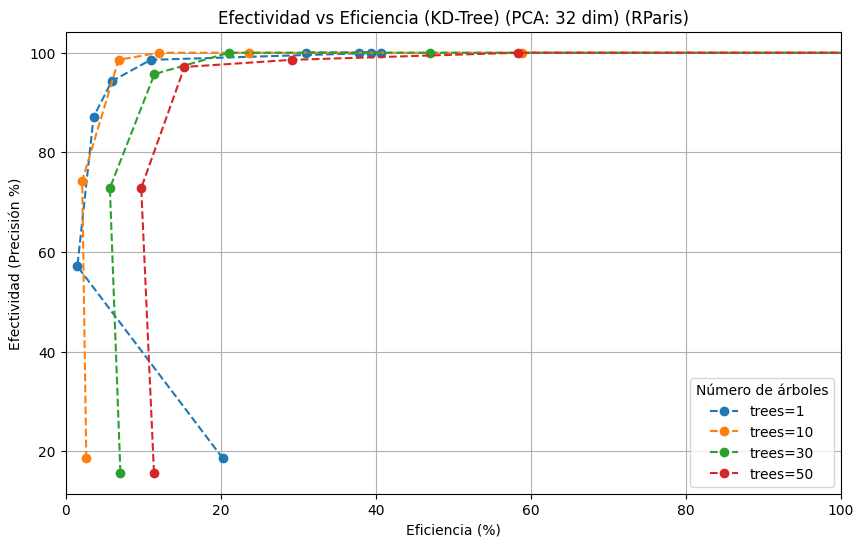

PCA: 64 dimensiones


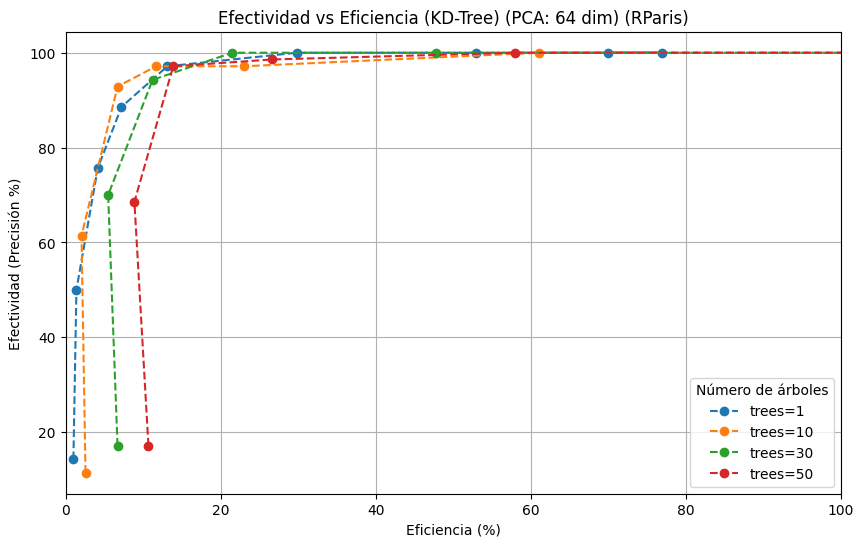

PCA: 128 dimensiones


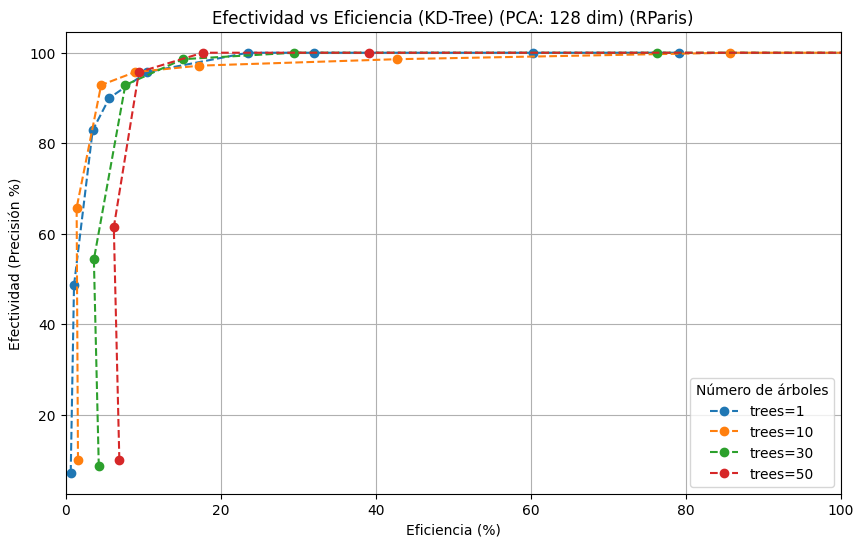

PCA: 256 dimensiones


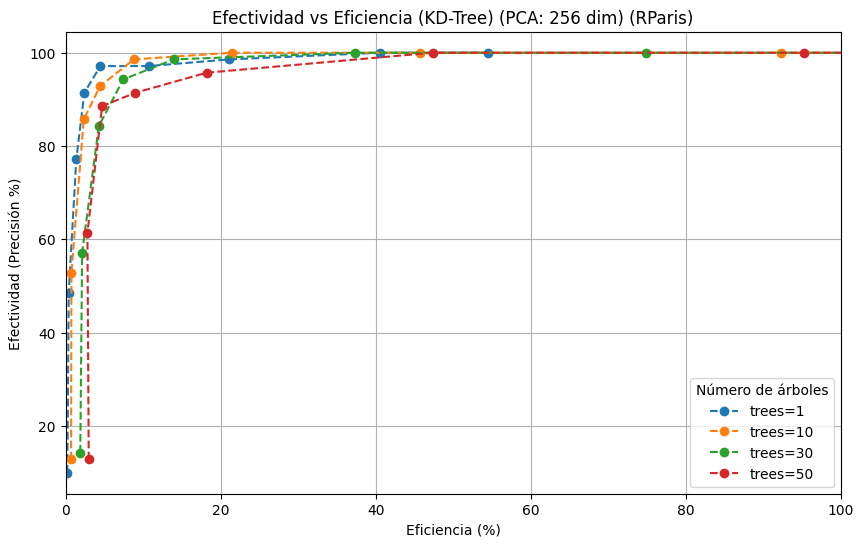

PCA: 512 dimensiones


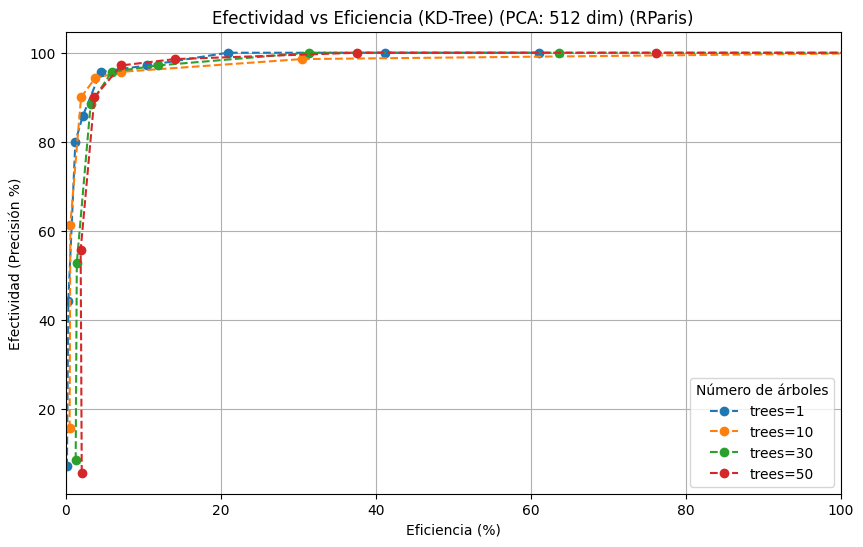

PCA: 1024 dimensiones


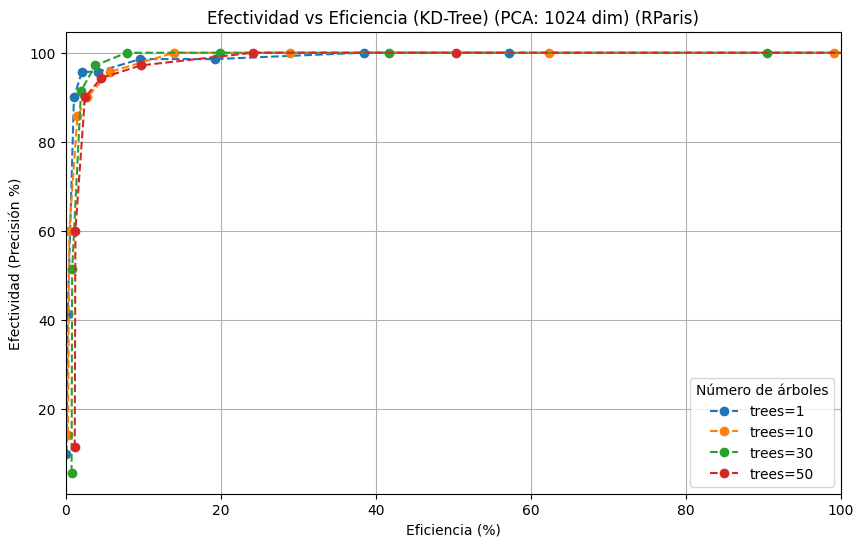

In [ ]:
# Define dimensions for PCA reduction
dimensiones = [32, 64, 128, 256, 512, 1024]  # PCA dimensions to test
trees_values = [1, 10, 30, 50]  # Number of trees for KD-Tree
checks_values = [1, 10, 50, 100, 200, 500, 1000, 2000, 3000]  # Number of checks to control trade-off

# Loop through the different PCA dimensions
for dim in dimensiones:
    print(f"PCA: {dim} dimensiones")

    # Apply PCA to reduce dimensionality of the database and query features
    pca = PCA(n_components=dim)
    db_features_pca = pca.fit_transform(test_rparis_db_features) # Reduce the database features
    query_features_pca = pca.transform(test_rparis_query_features) # Reduce the query features

    # Create a FLANN object for Linear Scan
    flann = pyflann.FLANN()
    # Build the index using the 'linear' algorithm for an exact search
    flann.build_index(db_features_pca, algorithm='linear')
    # Measure the time for the Linear Scan
    t0 = time.time()
    # Perform the 1-Nearest Neighbor search
    nns_LS, dists_LS = flann.nn_index(query_features_pca, num_neighbors=1, cores=1)
    # Calculate the time taken for the search
    segundos_LS = time.time() - t0

    # Dictionary to store results for the KD-Tree searches
    resultados = {}

    # Loop through the different values of 'trees' for KD-Tree
    for trees in trees_values:
        precisiones = []  # Store precision results for the current 'trees' value
        eficiencias = []  # Store efficiency results for the current 'trees' value

        # Initialize a new FLANN object for KD-Tree search
        flann = pyflann.FLANN()
        # Build the KD-Tree index with the current number of trees
        flann.build_index(db_features_pca, algorithm='kdtree', trees=trees)

        # Test the KD-Tree search with different 'checks' values
        for checks in checks_values:
            t0 = time.time()
            # Perform the 1-Nearest Neighbor search using KD-Tree
            nns_KDTree, dists_KDTree = flann.nn_index(query_features_pca, num_neighbors=1, cores=1, checks=checks)
            segundos_KDTree = time.time() - t0 # Measure the search time

            # Evaluate the KD-Tree search results against the Linear Scan baseline
            precision_KDTree, eficiencia_KDTree, _, _ = evaluar_busqueda(nns_KDTree, dists_KDTree, segundos_KDTree, nns_LS, dists_LS)

            # Append the results for the current 'checks' value
            precisiones.append(precision_KDTree)
            eficiencias.append(eficiencia_KDTree)

        # Store the results for the current 'trees' value
        resultados[trees] = {"eficiencias": eficiencias, "precisiones": precisiones}

    # Plot the results for the current PCA dimension
    plt.figure(figsize=(10, 6))
    for trees, data in resultados.items():
        # Plot each curve with efficiency on the x-axis and precision on the y-axis
        plt.plot(data["eficiencias"], data["precisiones"], label=f"trees={trees}", marker='o', linestyle='dashed')

    # Configure the plot
    plt.xlim(0, 100)
    plt.title(f"Efectividad vs Eficiencia (KD-Tree) (PCA: {dim} dim) (RParis)")
    plt.xlabel("Eficiencia (%)")
    plt.ylabel("Efectividad (Precisión %)")
    plt.grid(True)
    plt.legend(title="Número de árboles")
    plt.show()